In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.patches as mpatches
import os
import json

2024-05-08 17:27:45.381804: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 17:27:45.584552: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Set matplotlib default color cycle
new_color_cycle = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#c7c7c7',
    '#dbdb8d',
    '#9edae5'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

In [10]:
# This is the list that will hold all of the data (data22 and MC)

datasets = {}
pass_HLT = {}
pass_L1 = {}
weights = {}

## Collect Data

In [11]:
# Read EB file
with h5py.File('../../../../ntuples/AOD_EB_ntuples_04-10-2024.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]

# Concatenate HLT data
HLT_objects = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)

# Indices of events that passed L1
pass_L1_idxs = (pass_L1_unprescaled == 1)

# Indices of events that passed HLT
pass_HLT_idxs = (pass_HLT_unprescaled == 1)

# Append to datasets
datasets['HLT_data'] = HLT_objects[pass_L1_idxs][:, :, [0, 2, 3]]
weights['HLT_data'] = EB_weights[pass_L1_idxs]
pass_L1['HLT_data'] = pass_L1_idxs[pass_L1_idxs]
pass_HLT['HLT_data'] = pass_HLT_idxs[pass_L1_idxs]

datasets['L1_data'] = L1_objects[pass_L1_idxs]
weights['L1_data'] = EB_weights[pass_L1_idxs]
pass_L1['L1_data'] = pass_L1_idxs[pass_L1_idxs]
pass_HLT['L1_data'] = pass_HLT_idxs[pass_L1_idxs]

datasets['HLT_zerobias'] = HLT_objects[~pass_L1_idxs][:, :, [0, 2, 3]]
weights['HLT_zerobias'] = EB_weights[~pass_L1_idxs]
pass_L1['HLT_zerobias'] = pass_L1_idxs[~pass_L1_idxs]
pass_HLT['HLT_zerobias'] = pass_HLT_idxs[~pass_L1_idxs]

datasets['L1_zerobias'] = L1_objects[~pass_L1_idxs]
weights['L1_zerobias'] = EB_weights[~pass_L1_idxs]
pass_L1['L1_zerobias'] = pass_L1_idxs[~pass_L1_idxs]
pass_HLT['L1_zerobias'] = pass_HLT_idxs[~pass_L1_idxs]

datasets['HLT_passedHLT'] = HLT_objects[pass_HLT_idxs][:, :, [0, 2, 3]]
weights['HLT_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['HLT_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['HLT_passedHLT'] = pass_HLT_idxs[pass_L1_idxs]

datasets['L1_passedHLT'] = L1_objects[pass_HLT_idxs]
weights['L1_passedHLT'] = EB_weights[pass_HLT_idxs]
pass_L1['L1_passedHLT'] = pass_L1_idxs[pass_HLT_idxs]
pass_HLT['L1_passedHLT'] = pass_HLT_idxs[pass_L1_idxs]

In [12]:
# Read MC data. Remove E.

filenames = ['Ztautau',
             #'HHbbttHadHad.h5', 
             'ZZ4lep',  
             #'jjJZ4.h5', 
             #'jjJZ2.h5', 
             'qqa', 
             'HNL7p5_ctau1_eemu',
             'Zprime2EJs',
             'HAHMggfZdZd2l2nu']
data_path = '../../../../ntuples/MC/'

for filename in filenames:
    with h5py.File(data_path+filename+'.h5', 'r') as hf:
        jets = hf['HLT_jets'][:]
        electrons = hf['electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        muons = hf['muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        photons = hf['photons'][:]
        MET = hf['MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        pass_HLT_unprescaled = hf['pass_HLT_unprescaled'][:]
        # Indices of events that passed L1
        pass_L1_idxs = (pass_L1_unprescaled == 1)
        
        # Indices of events that passed HLT
        pass_HLT_idxs = (pass_HLT_unprescaled == 1)

        combined_data = np.concatenate([jets, electrons, muons, photons, MET], axis=1)
        datasets['HLT_'+filename] = combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]]
        pass_HLT['HLT_'+filename] = pass_HLT_idxs[0:min(len(combined_data), 100000)]
        pass_L1['HLT_'+filename] = pass_L1_idxs[0:min(len(combined_data), 100000)]
        weights['HLT_'+filename] = np.ones(min(len(combined_data), 100000))

In [13]:
# Read other MC data.

filenames = ['HHbbttHadHad',   
             'jjJZ4', 
             'jjJZ2'
            ]
data_path = '../../../../ntuples/L1_MC/'

for filename in filenames:
    with h5py.File(data_path+'HLT_'+filename+'_04-24-2024.h5', 'r') as hf:
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        # Indices of events that passed L1
        pass_L1_idxs = (pass_L1_unprescaled == 1)
        
        # Indices of events that passed HLT
        pass_HLT_idxs = (pass_HLT_unprescaled == 1)

        HLT_combined_data = np.concatenate([HLT_jets, HLT_electrons, HLT_muons, HLT_photons, HLT_MET], axis=1)
        datasets['HLT_'+filename] = HLT_combined_data[0:min(len(combined_data), 100000), :, [0, 2, 3]]
        pass_HLT['HLT_'+filename] = pass_HLT_idxs[0:min(len(combined_data), 100000)]
        pass_L1['HLT_'+filename] = pass_L1_idxs[0:min(len(combined_data), 100000)]
        weights['HLT_'+filename] = np.ones(min(len(combined_data), 100000))

        L1_objects = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_muons, L1_eFex_taus, L1_MET], axis=1)
        datasets['L1_'+filename] = L1_objects
        weights['L1_'+filename] = np.ones(len(L1_objects))
        pass_L1['L1_'+filename] = pass_L1_idxs
        pass_HLT['L1_'+filename] = pass_HLT_idxs

In [14]:
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (219467, 20, 3)
L1_data: (219467, 20, 3)
HLT_zerobias: (777848, 20, 3)
L1_zerobias: (777848, 20, 3)
HLT_passedHLT: (7850, 20, 3)
L1_passedHLT: (7850, 20, 3)
HLT_Ztautau: (100000, 20, 3)
HLT_ZZ4lep: (100000, 20, 3)
HLT_qqa: (50000, 20, 3)
HLT_HNL7p5_ctau1_eemu: (10000, 20, 3)
HLT_Zprime2EJs: (100000, 20, 3)
HLT_HAHMggfZdZd2l2nu: (70000, 20, 3)
HLT_HHbbttHadHad: (70000, 20, 3)
L1_HHbbttHadHad: (100000, 20, 3)
HLT_jjJZ4: (70000, 20, 3)
L1_jjJZ4: (100000, 20, 3)
HLT_jjJZ2: (70000, 20, 3)
L1_jjJZ2: (100000, 20, 3)


In [15]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for tag, data in datasets.items():

    # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
    MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
    MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
    MET_nan = np.isnan(data[:, 19, 2])
    data[MET_zeros, 19, 0] = 0.001
    data[MET_999, 19, :] = 0
    data[MET_nan, 19, :] = 0

## Make plots of the data

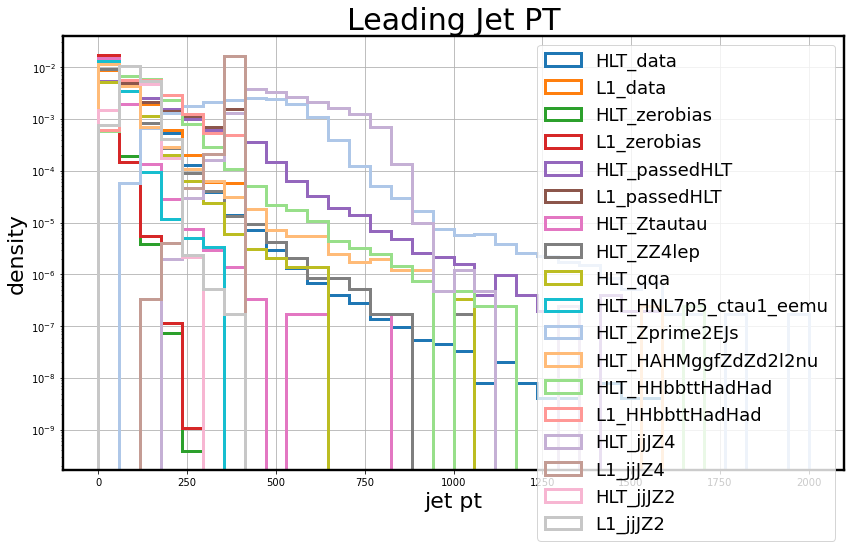

In [16]:
# Plotting pt distribtions of the jets from each dataset

plt.figure(figsize=(14, 8))
plt.rcParams['axes.linewidth'] = 2.4
bins = np.linspace(0, 2000, 35)
#bins=50

for tag, data in datasets.items():
    pt = data[:, 0, 0]
    nonzero_pt = pt[pt > 0]

    nonzero_weights = (weights[tag])[pt > 0]
    plt.hist(nonzero_pt, bins=bins, label=tag, histtype='step', density=True, fill=False, linewidth=3, weights=nonzero_weights)

plt.yscale('log')
plt.xlabel('jet pt', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.title('Leading Jet PT', fontsize=30)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [17]:
def plot_event(event, dataset_tag=''):
    '''Visual representation of an event. Plots objects in the eta-phi plane, with the pt being
    represented as the size of the marker.'''
    labels = {
        'Jet': 'blue',
        'Electron': 'yellow',
        'Muon': 'green',
        'Photon': 'red',
        'MET': 'black'
    }
    colors = 10*['blue'] + 3*['yellow'] + 3*['green'] + 3*['red'] + ['black']

    
    pt = event[:, 0]
    eta = event[:, 1]
    phi = event[:, 2]

    plt.figure(figsize=(10, 7))
    plt.scatter(phi, eta, s=pt*10, c=colors)

    legend_handles = []
    for obj_type, color in labels.items():
        legend_handles.append(mpatches.Patch(color=color, label=obj_type))

    plt.legend(handles=legend_handles, fontsize=14)

    plt.xlabel('Phi', fontsize=16)
    plt.ylabel('Eta', fontsize=16)
    plt.title(f'Spatial Distribution of Objects in {dataset_tag} Event', fontsize=20)
    plt.grid(True)
    plt.show()

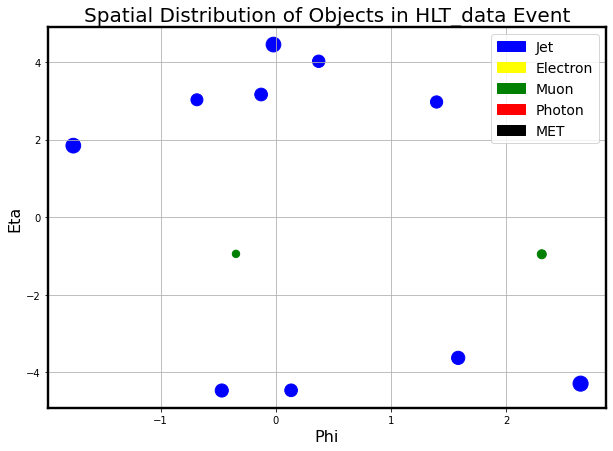

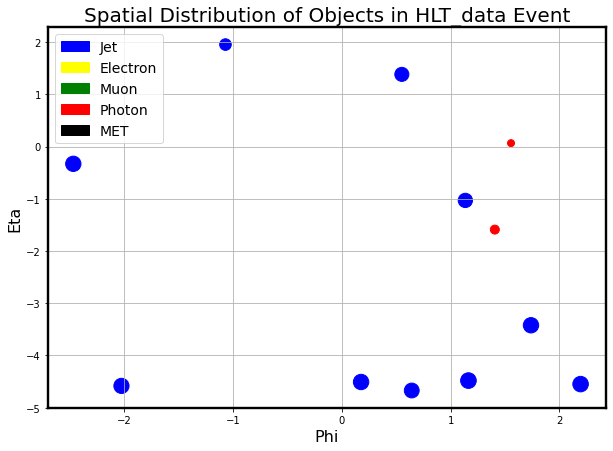

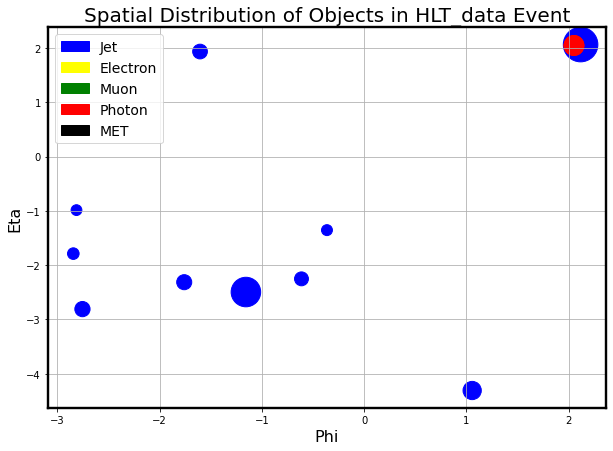

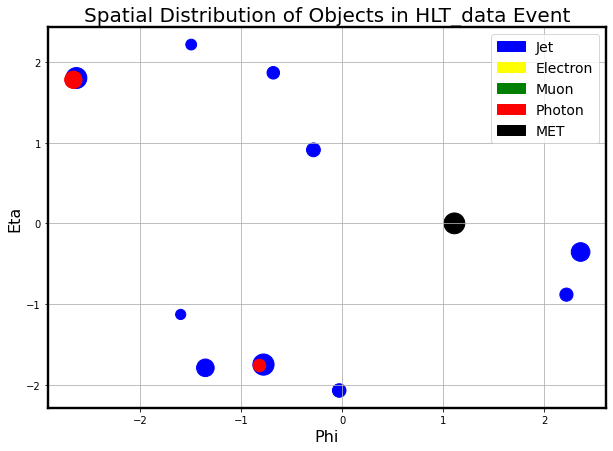

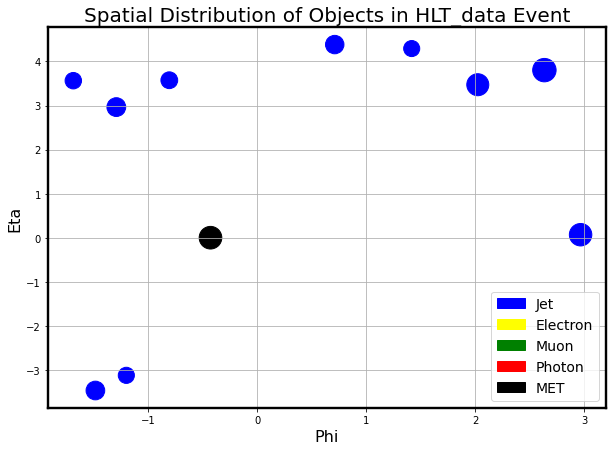

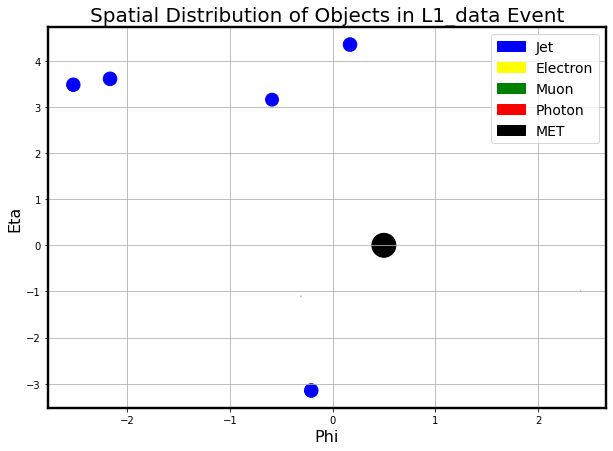

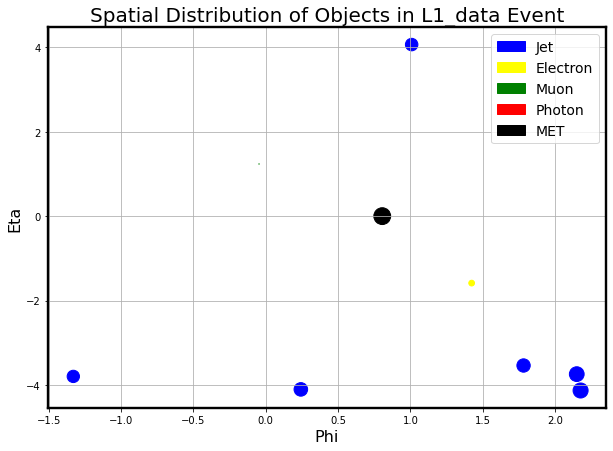

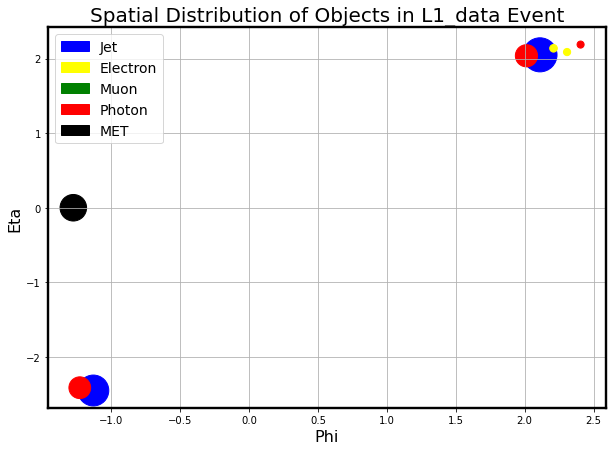

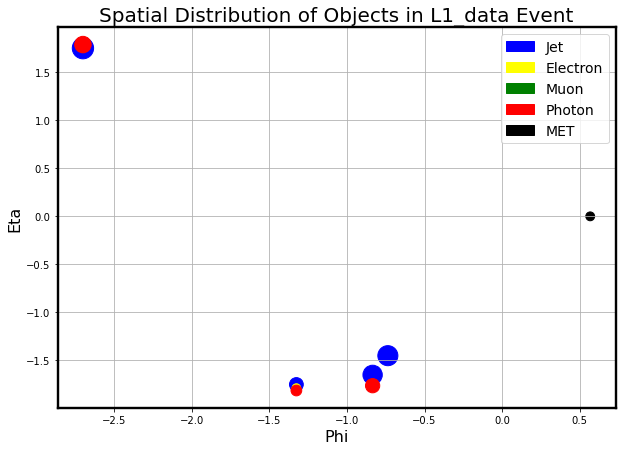

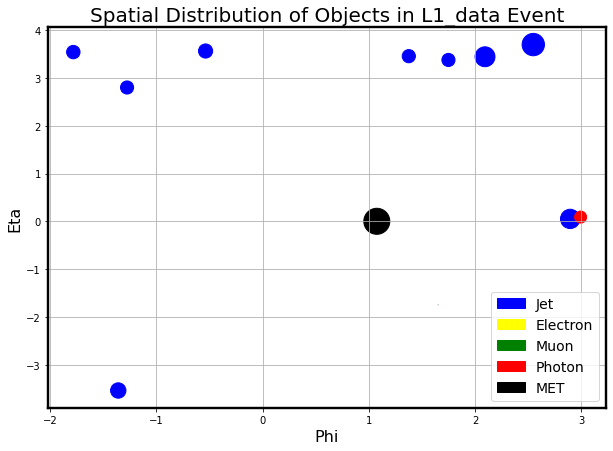

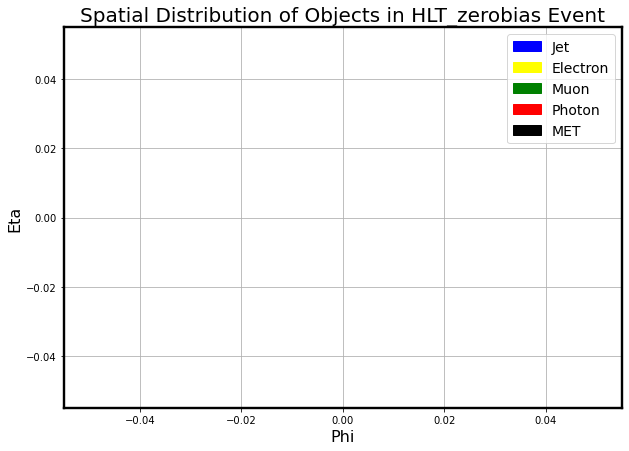

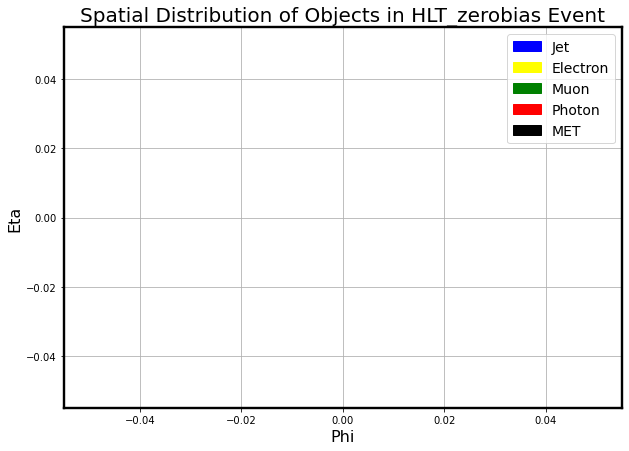

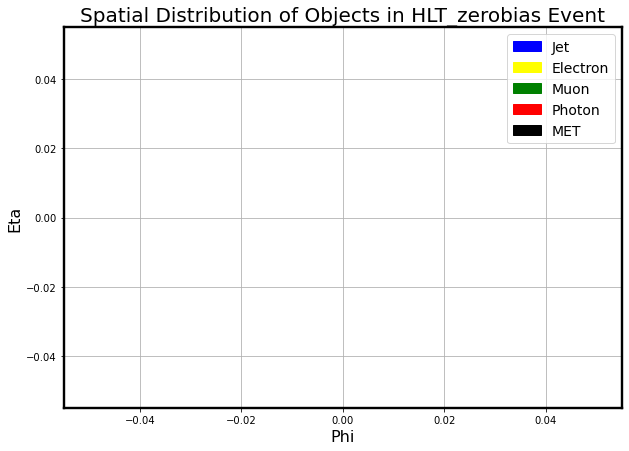

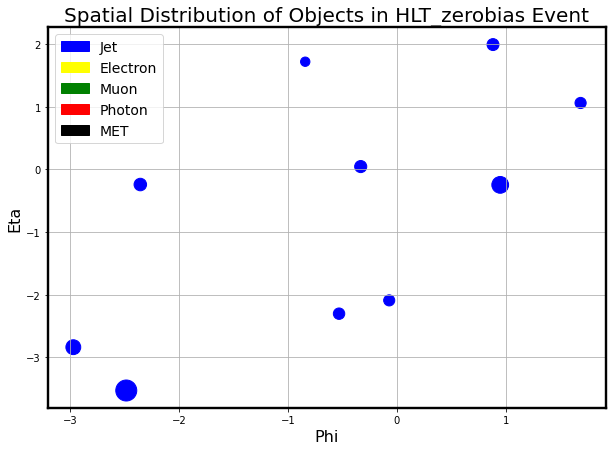

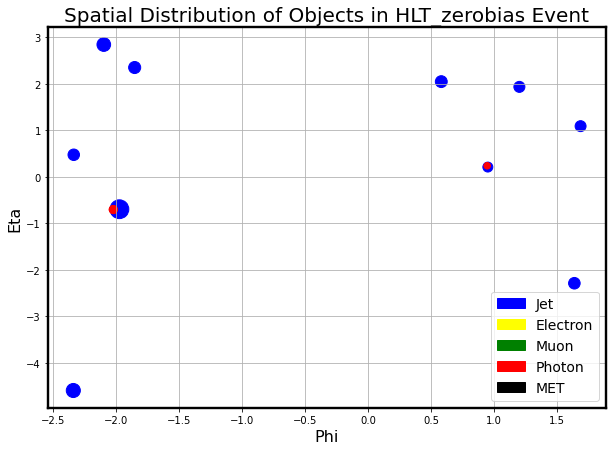

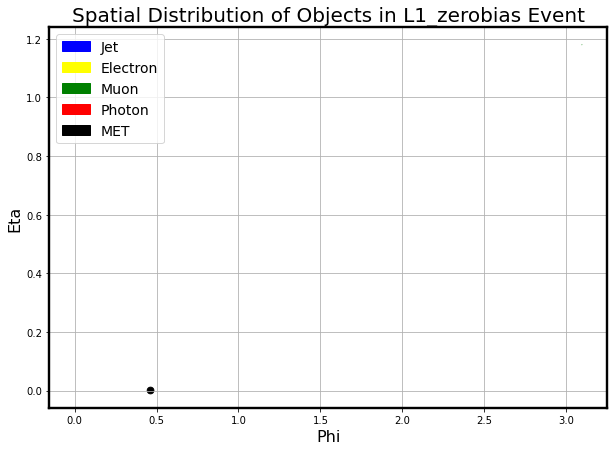

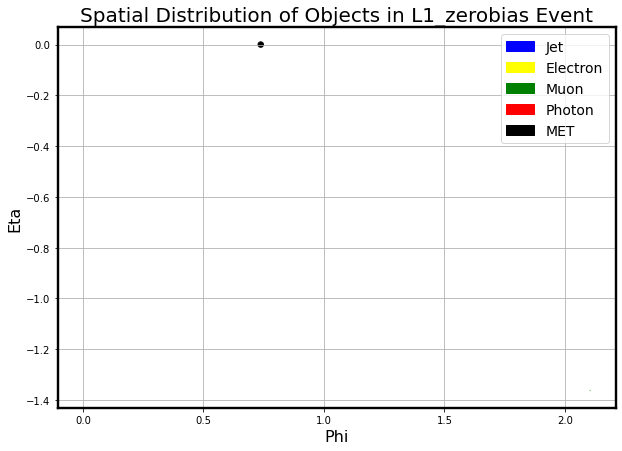

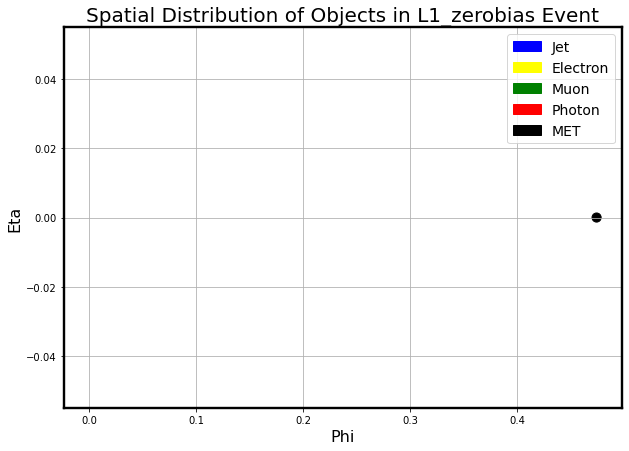

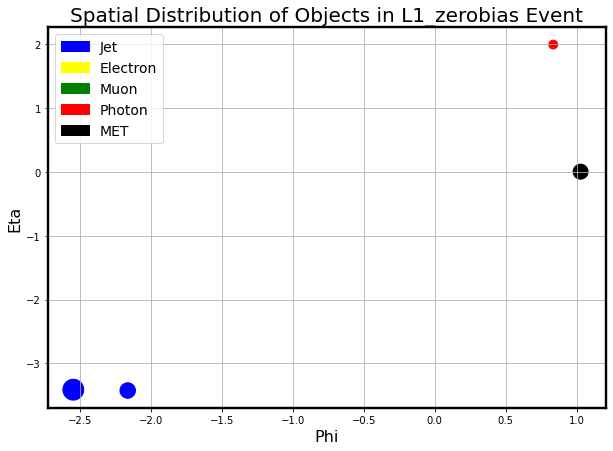

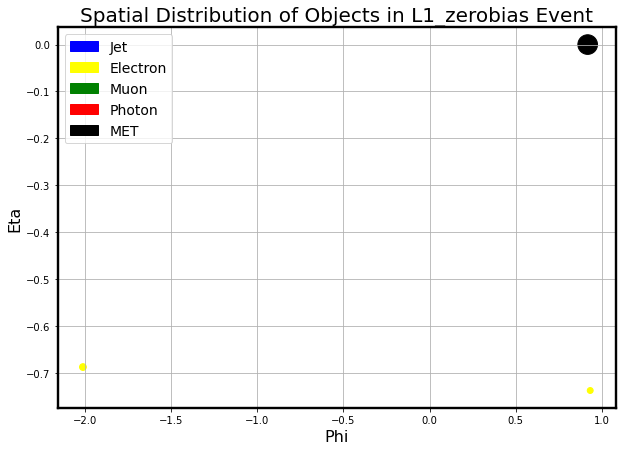

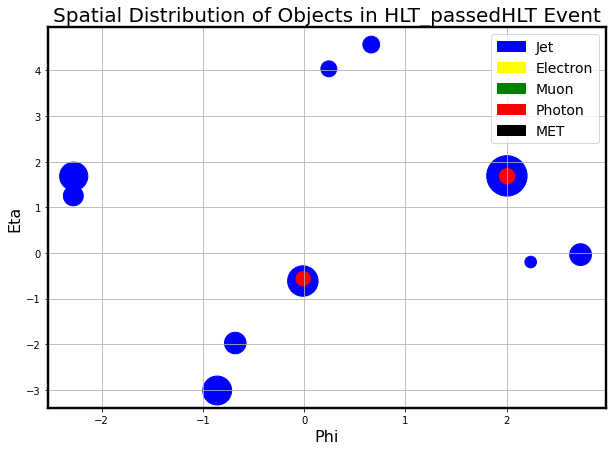

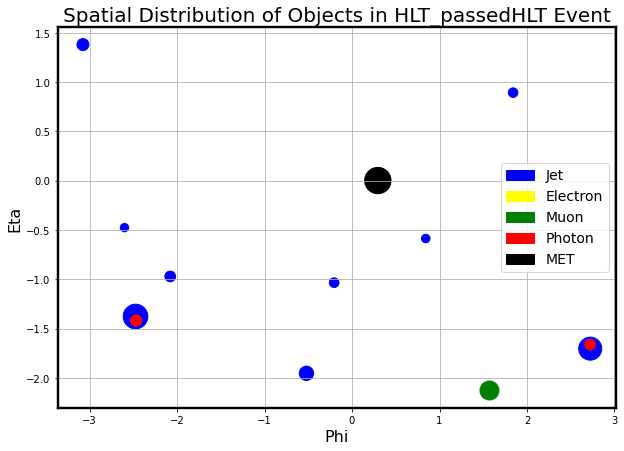

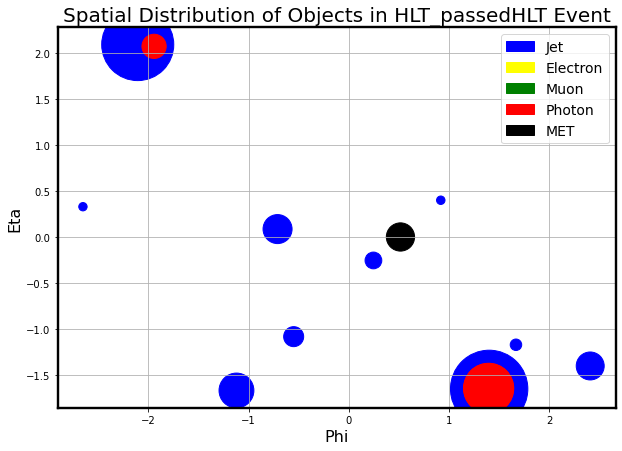

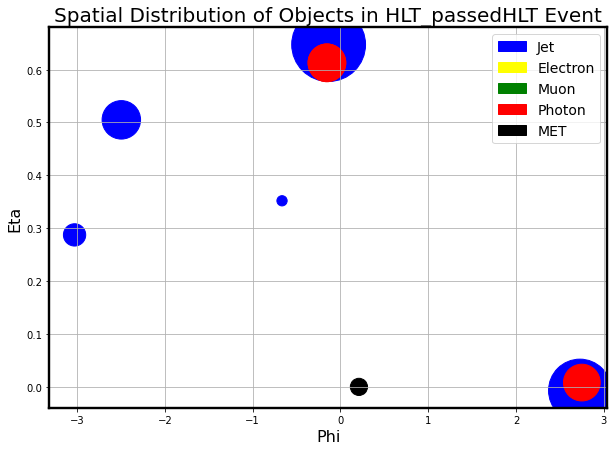

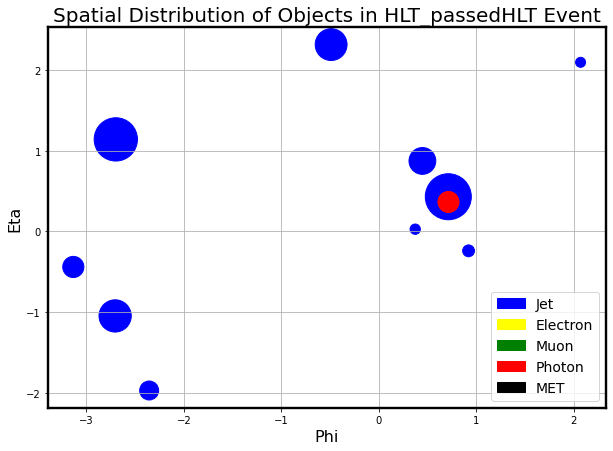

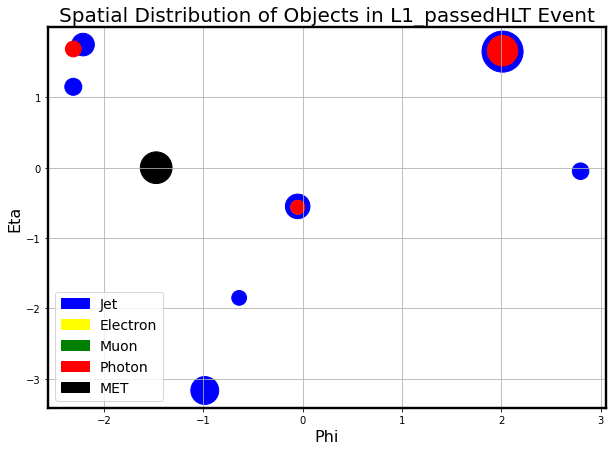

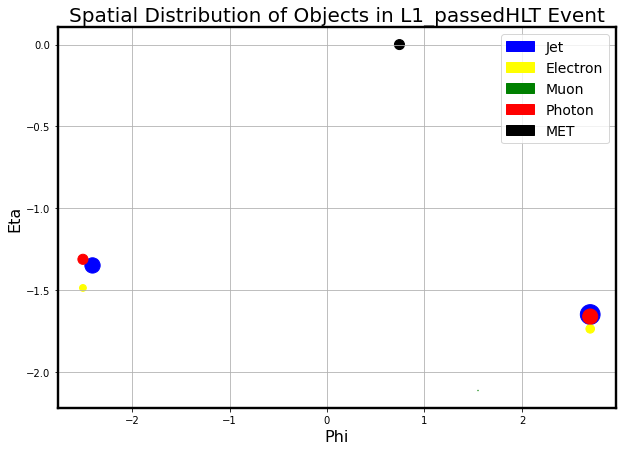

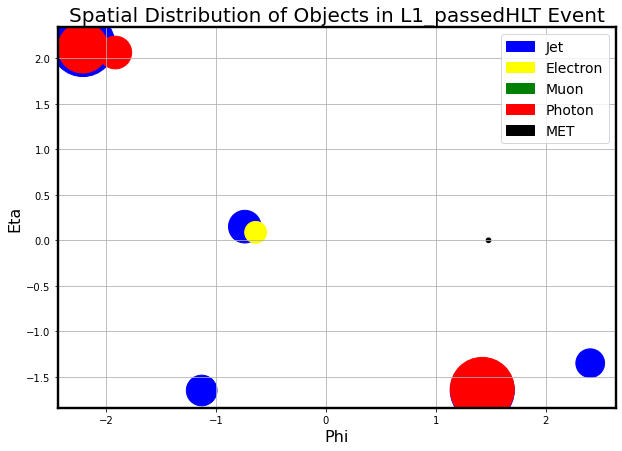

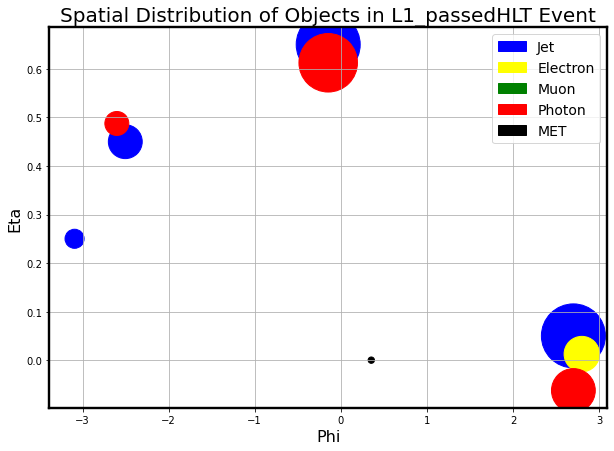

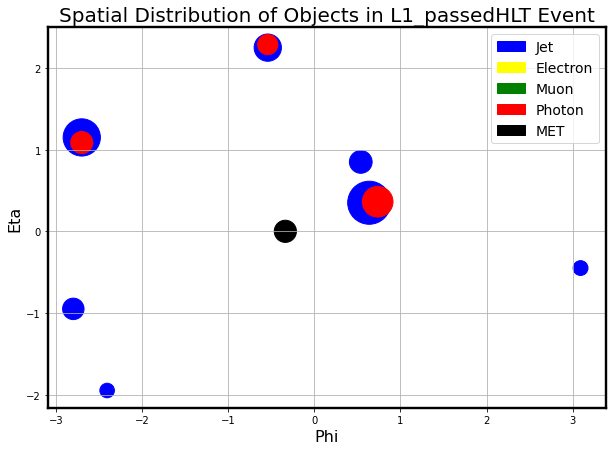

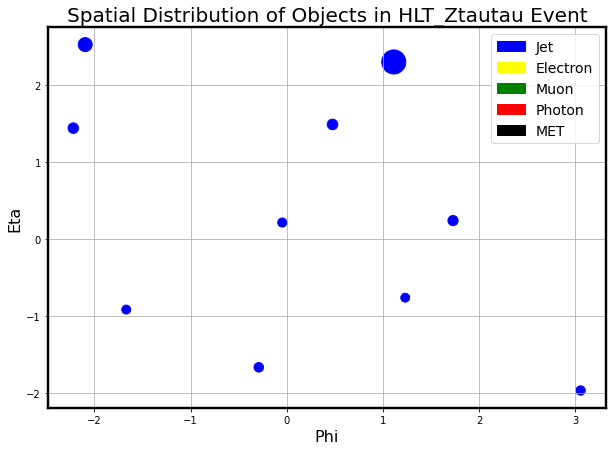

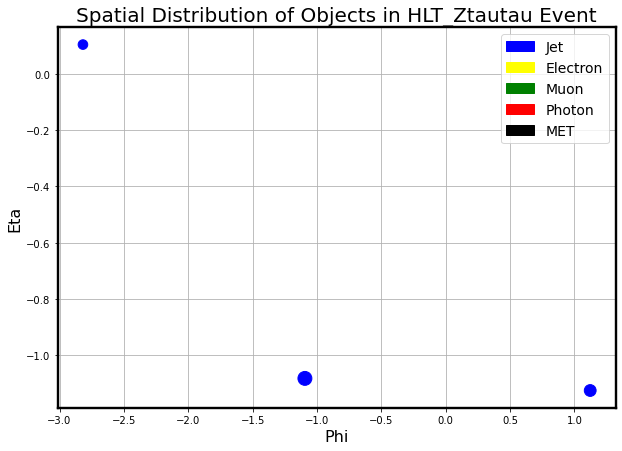

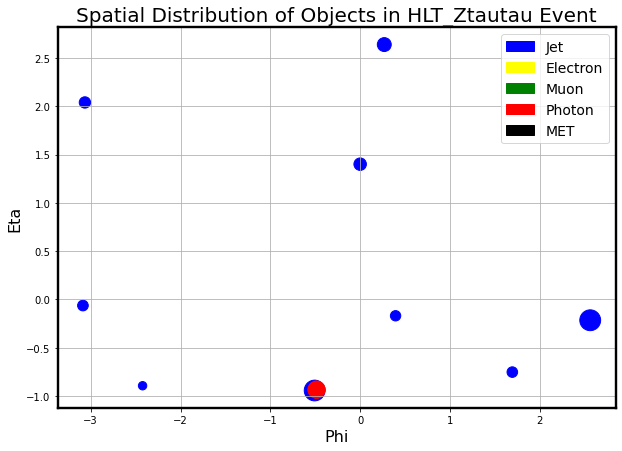

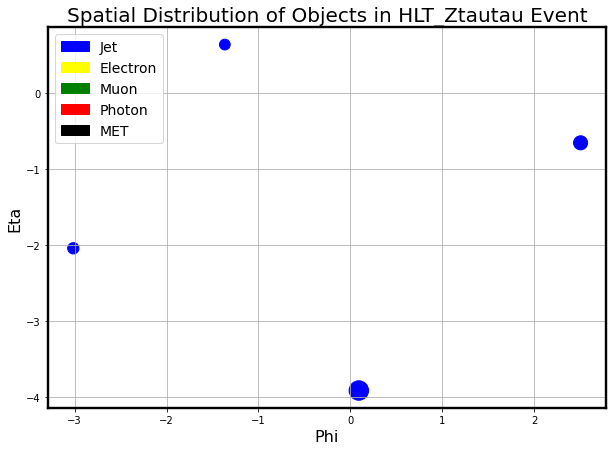

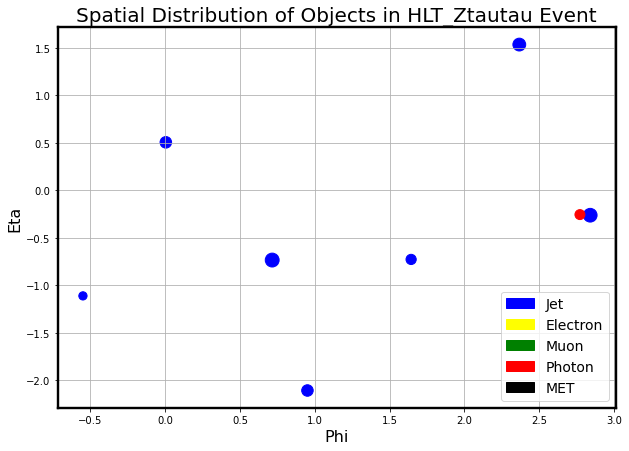

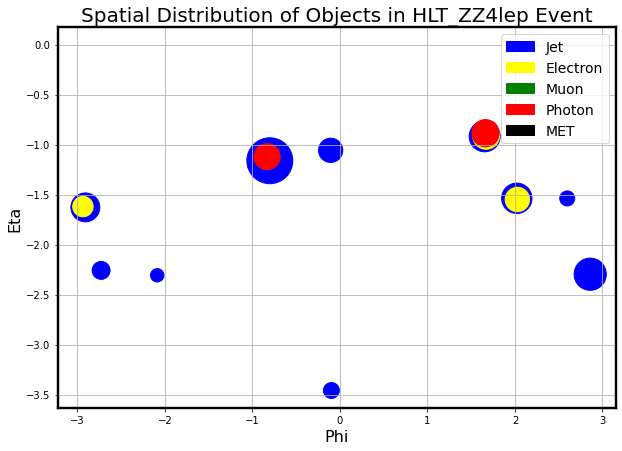

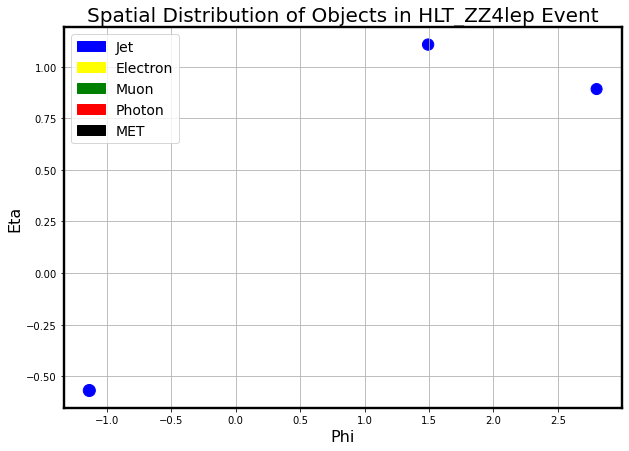

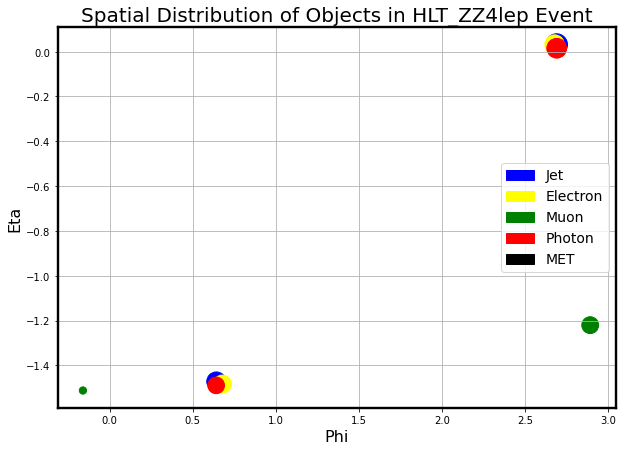

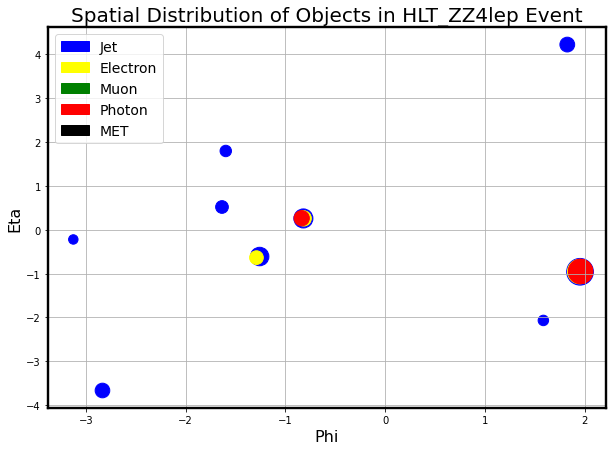

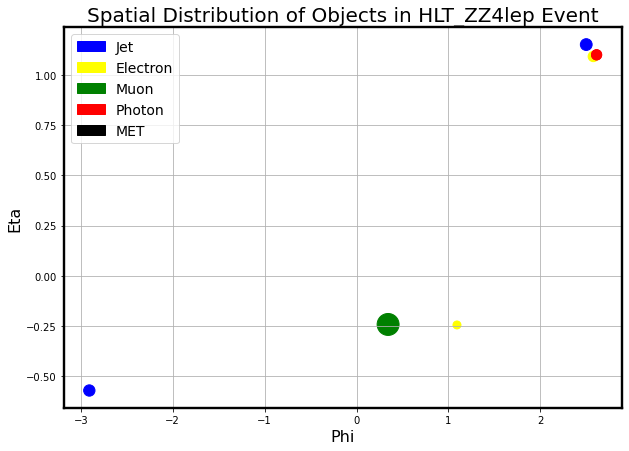

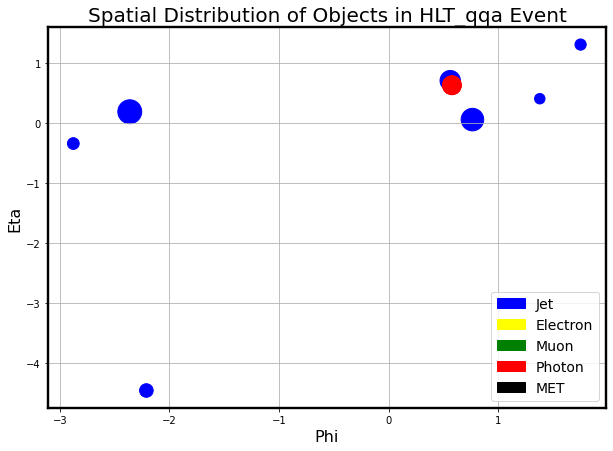

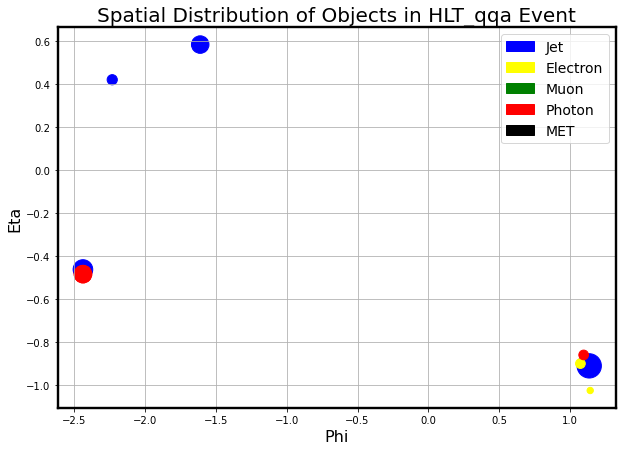

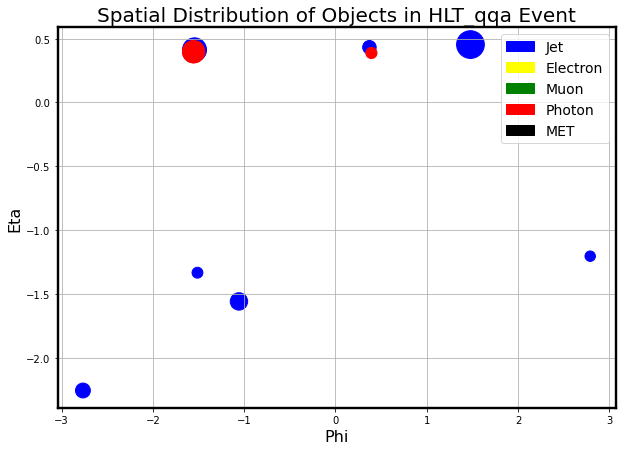

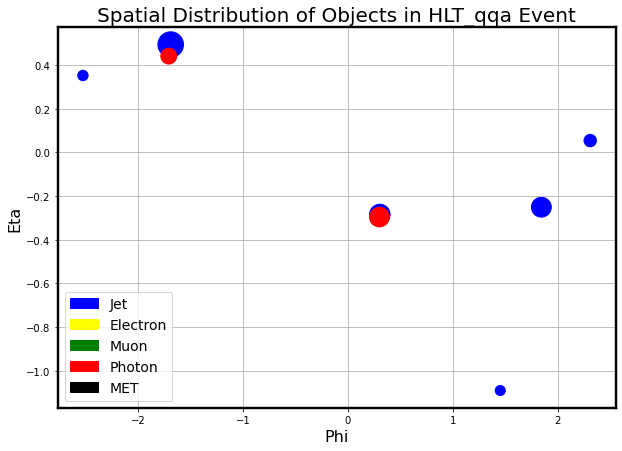

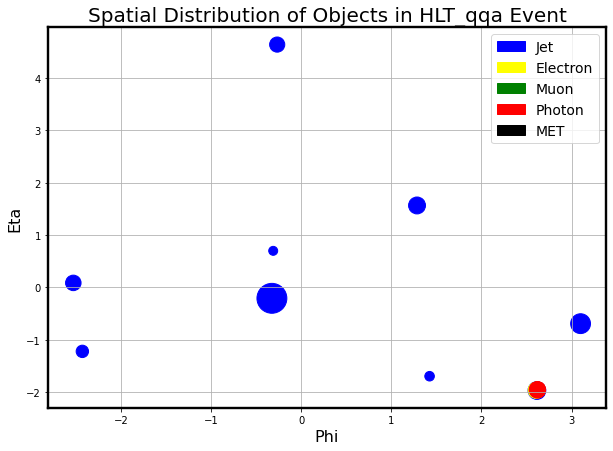

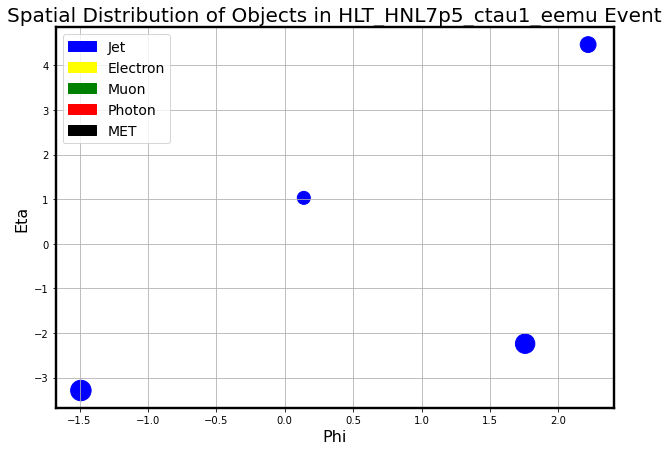

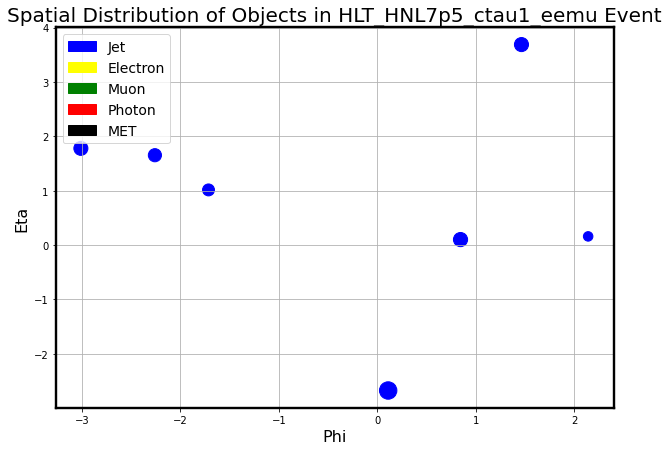

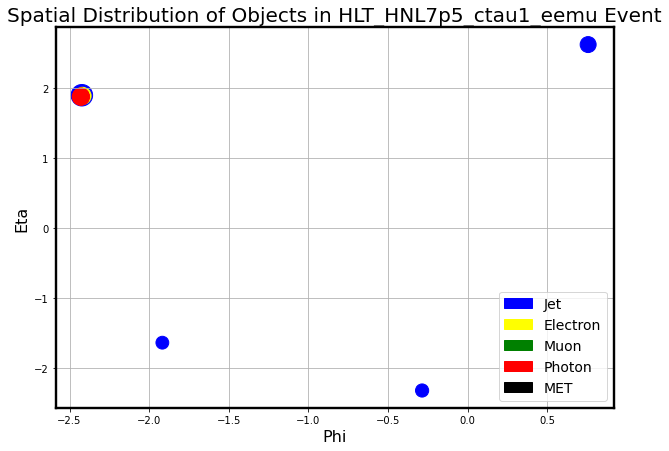

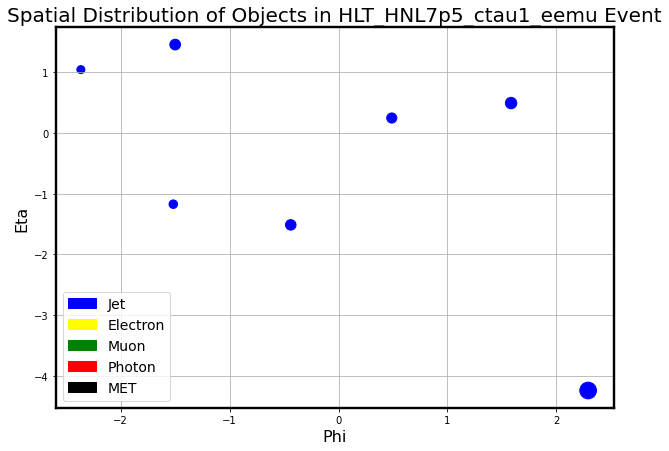

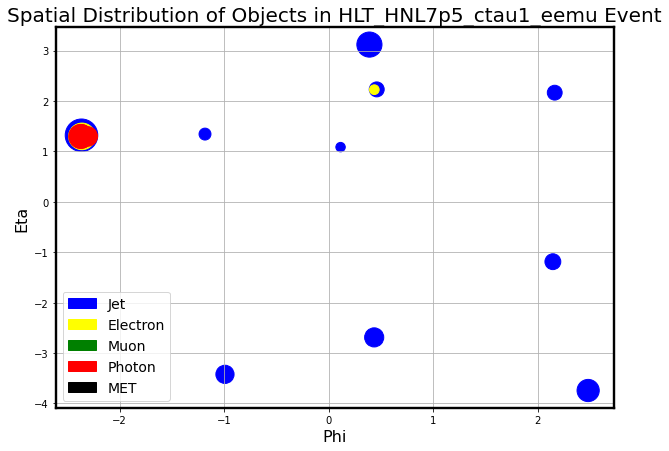

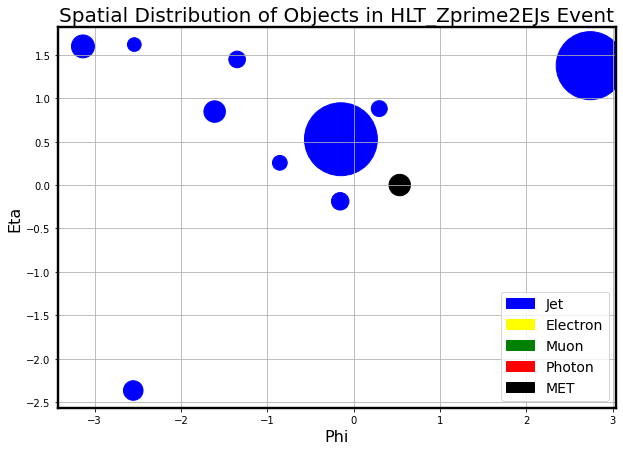

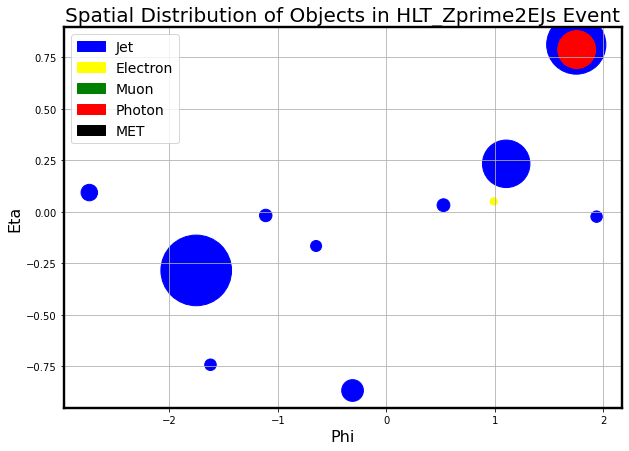

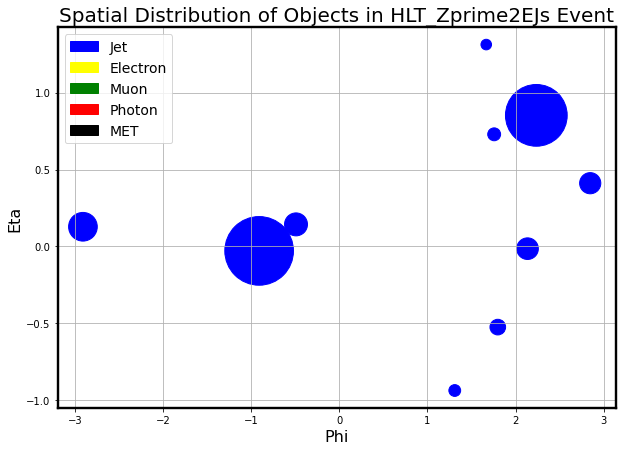

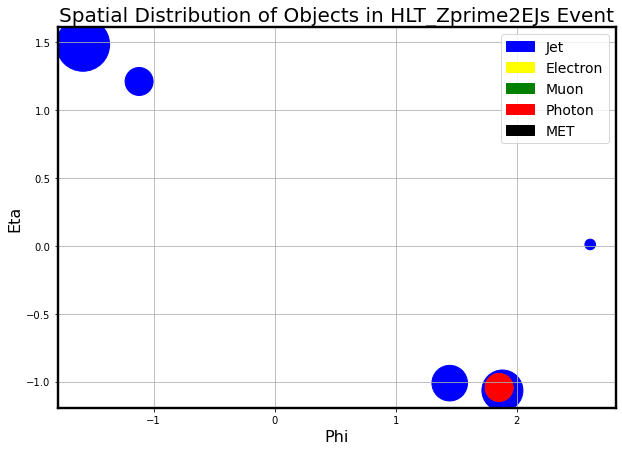

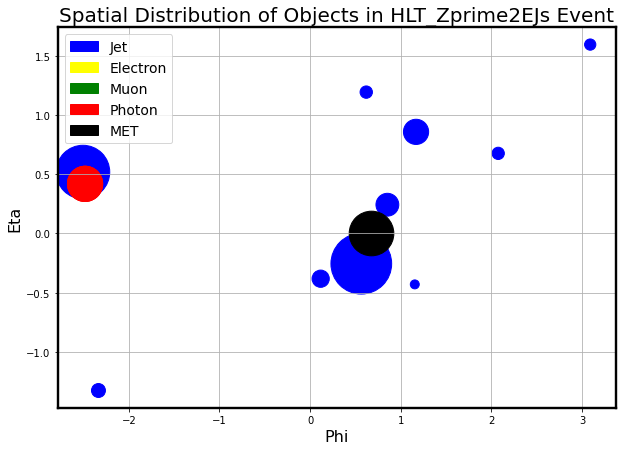

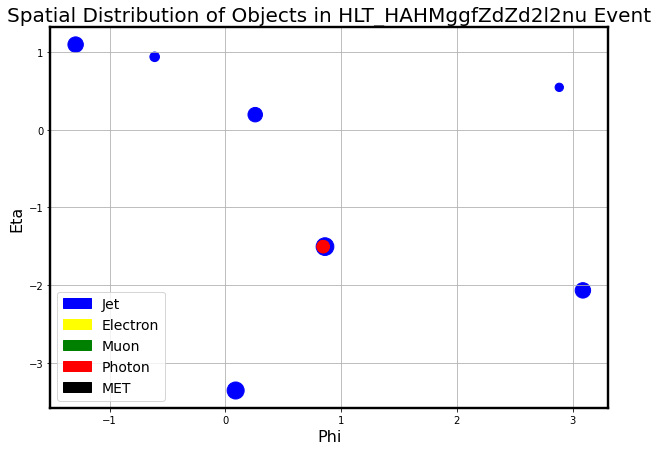

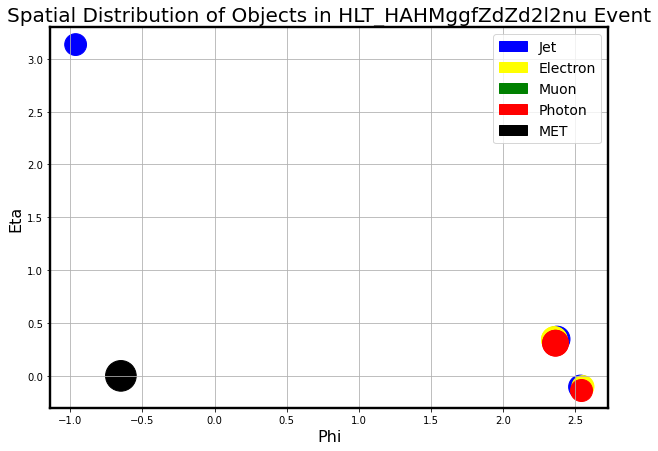

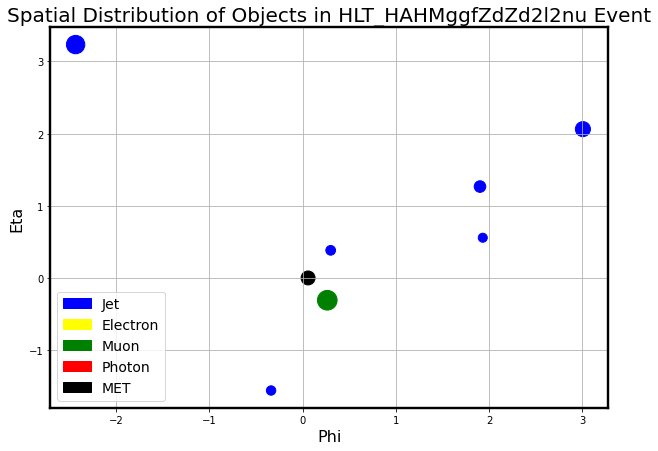

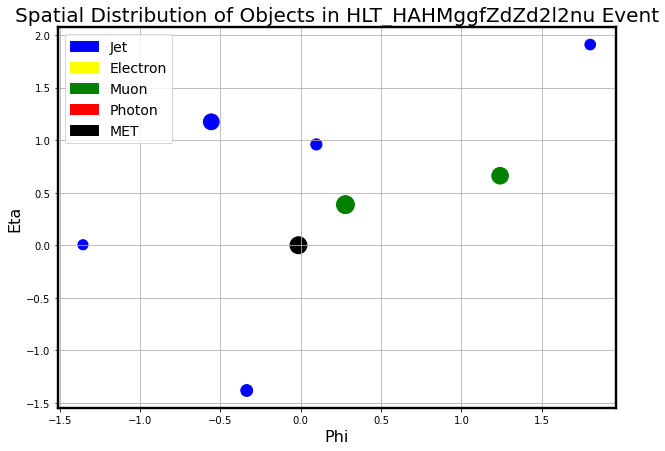

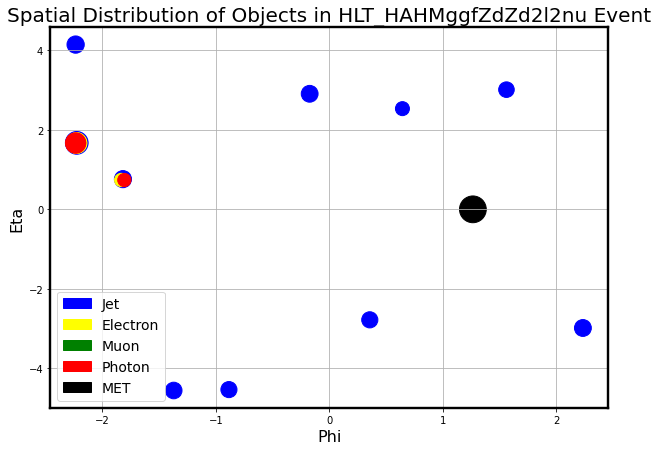

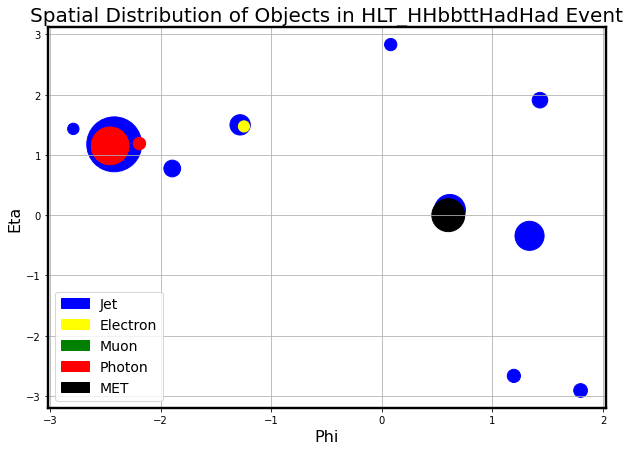

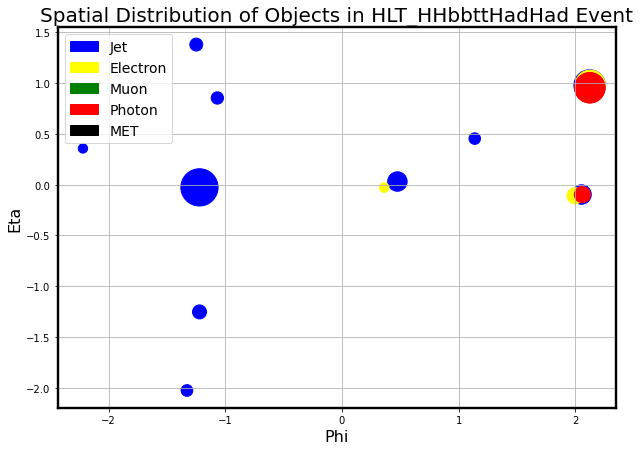

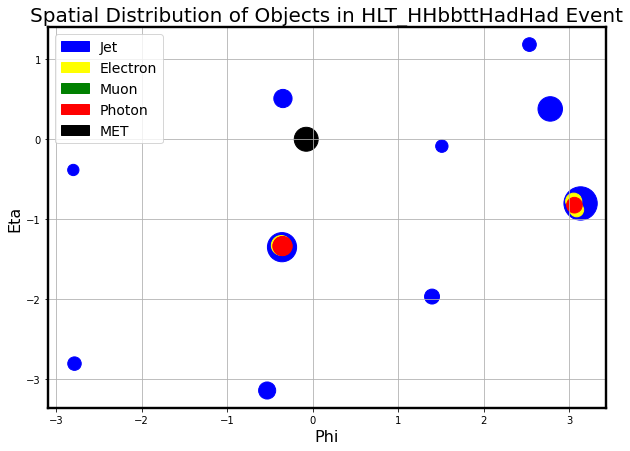

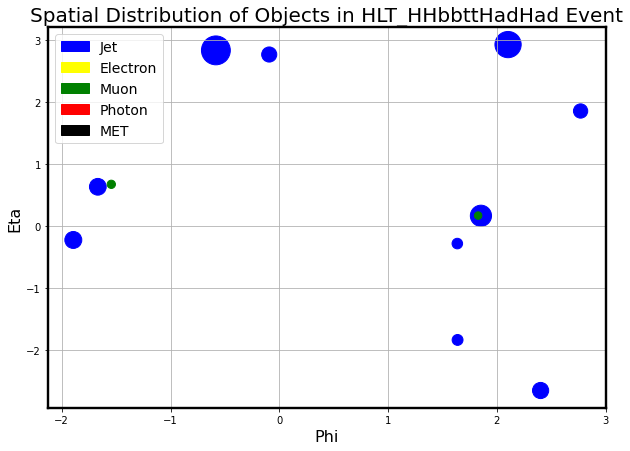

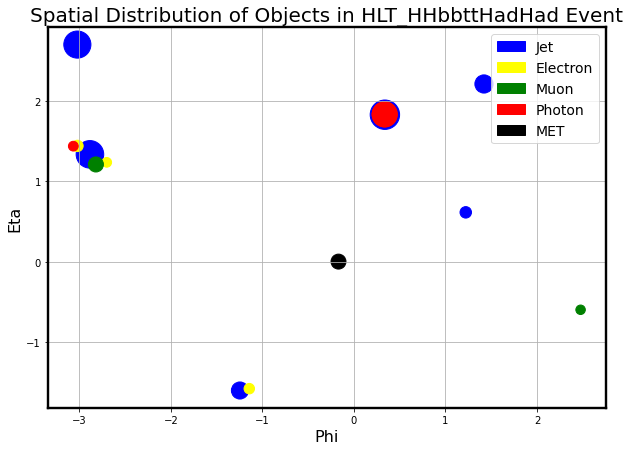

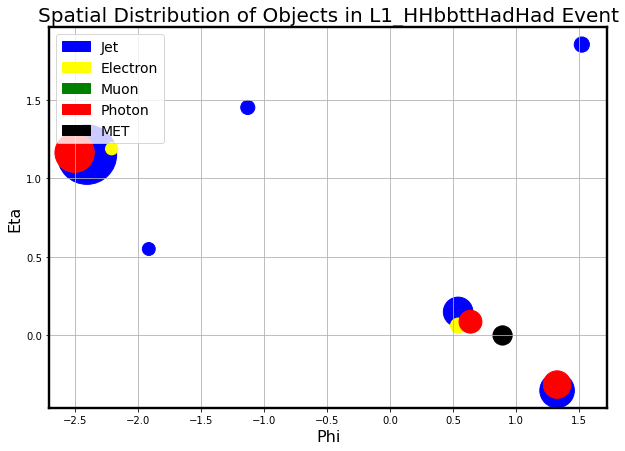

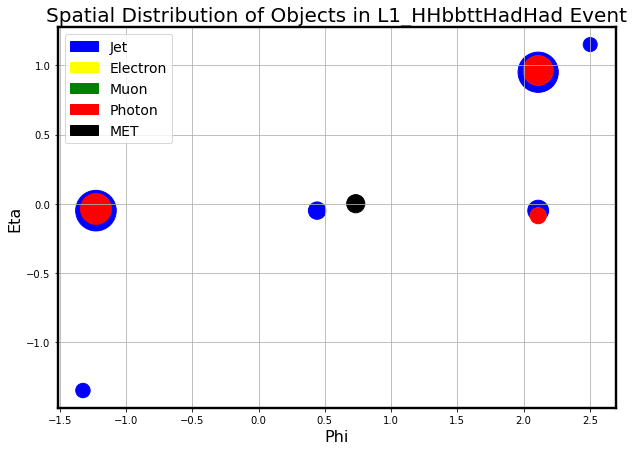

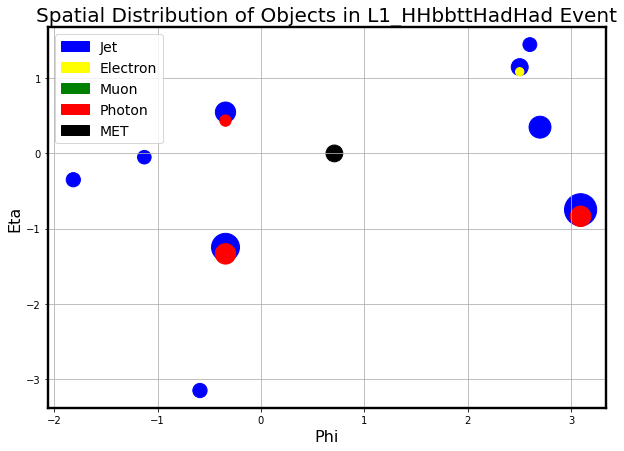

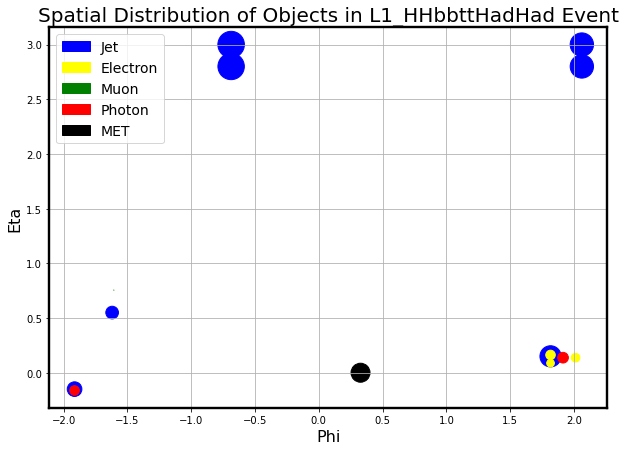

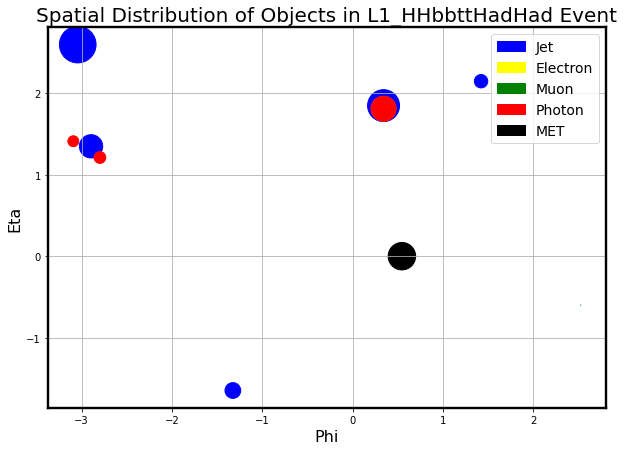

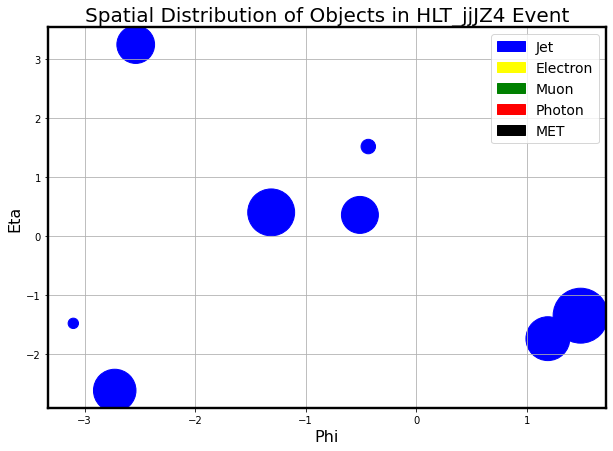

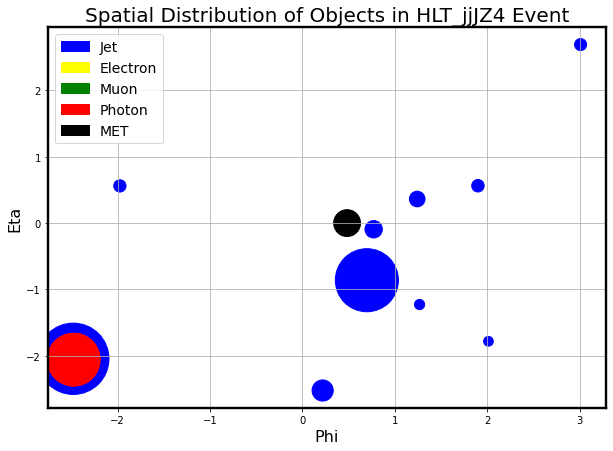

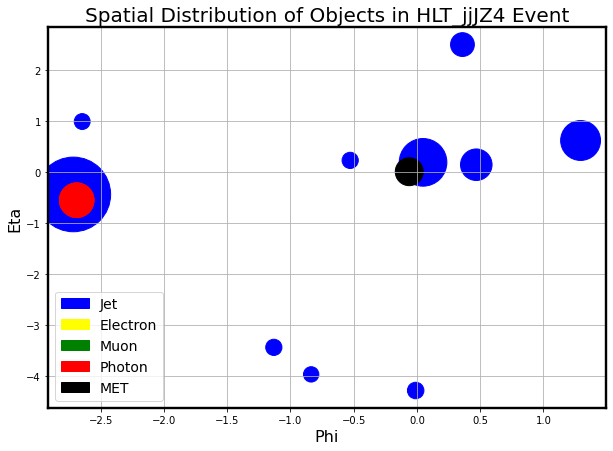

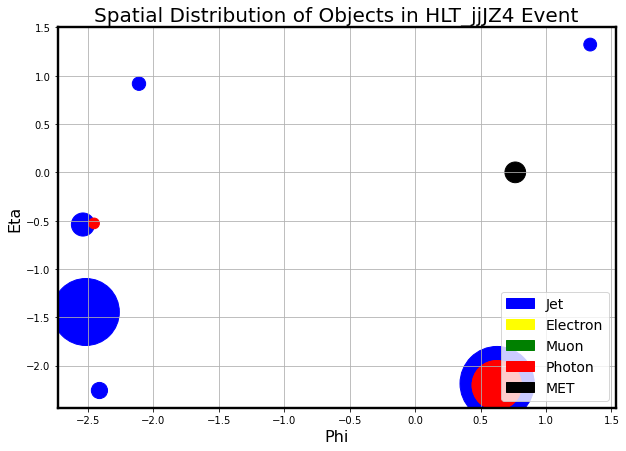

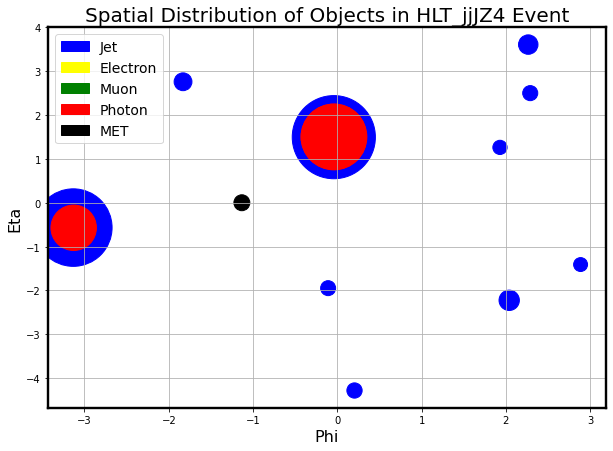

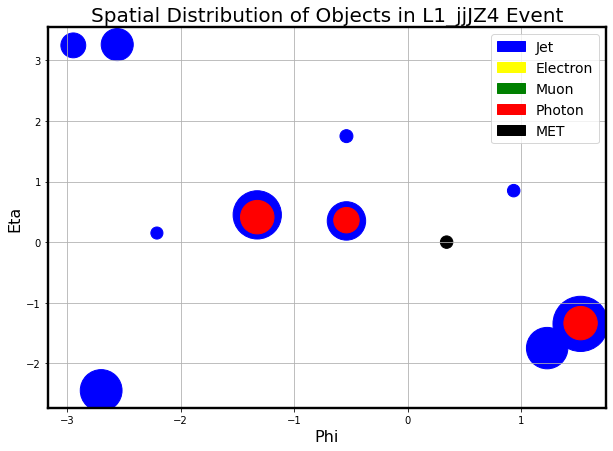

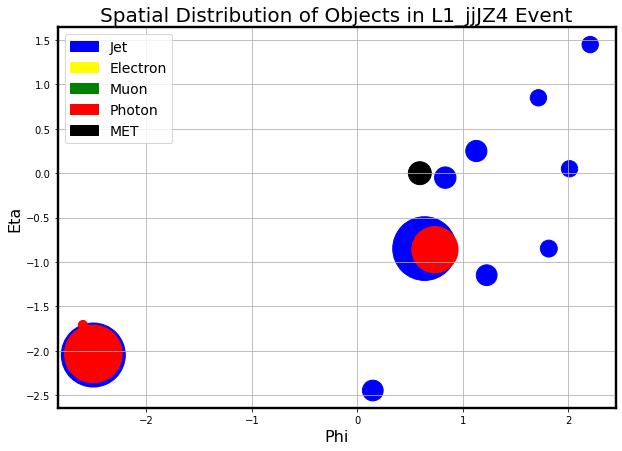

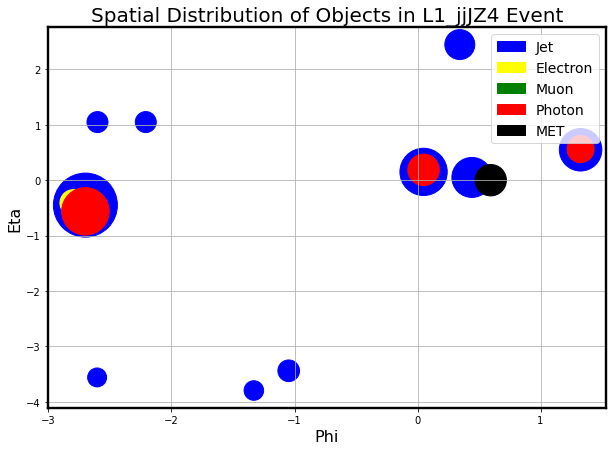

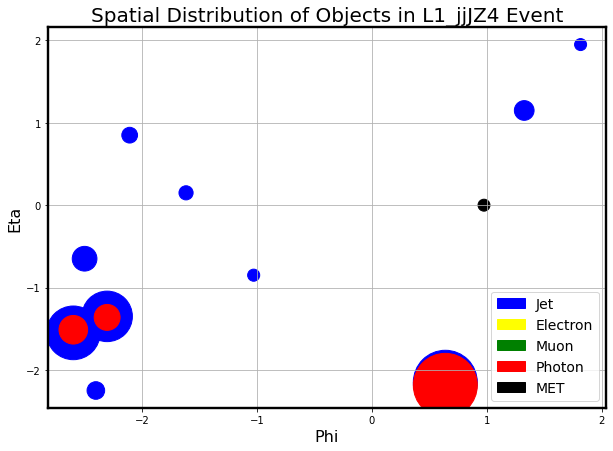

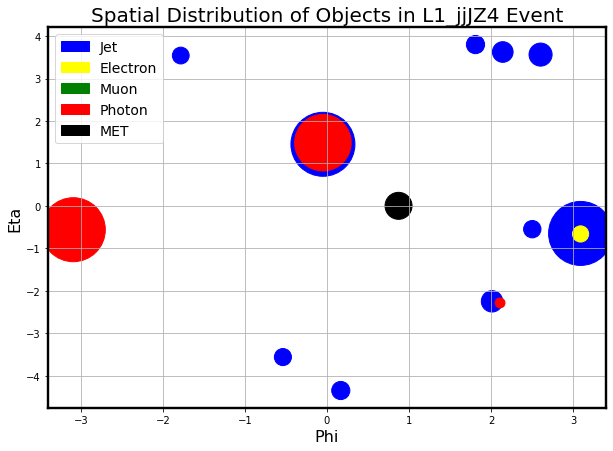

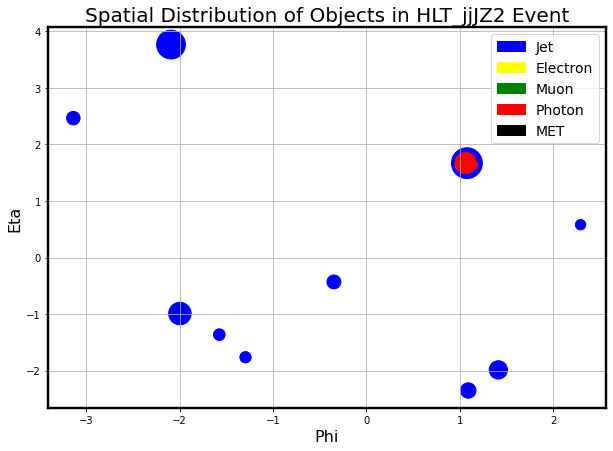

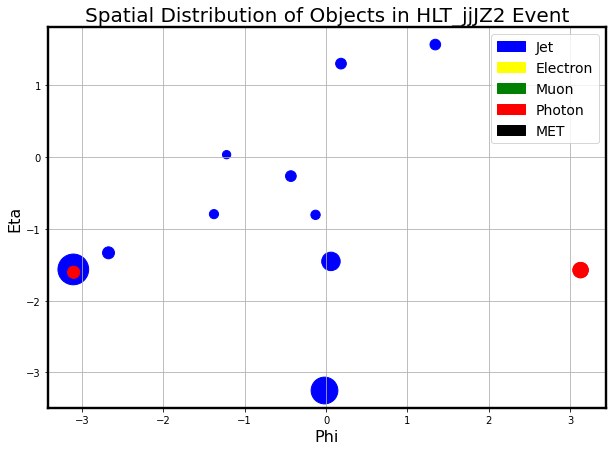

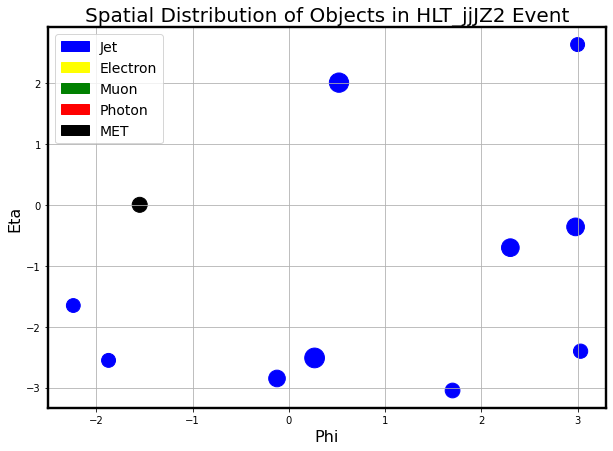

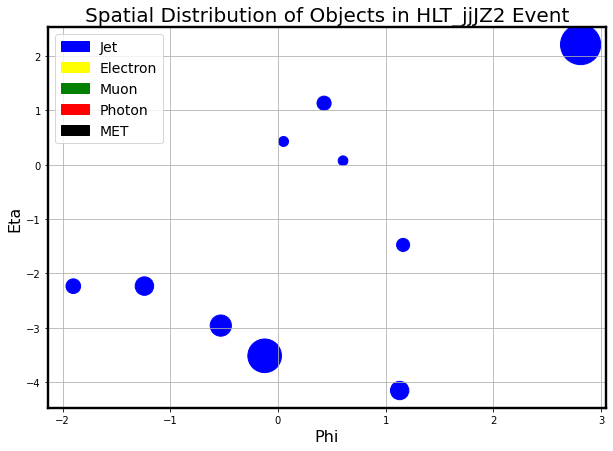

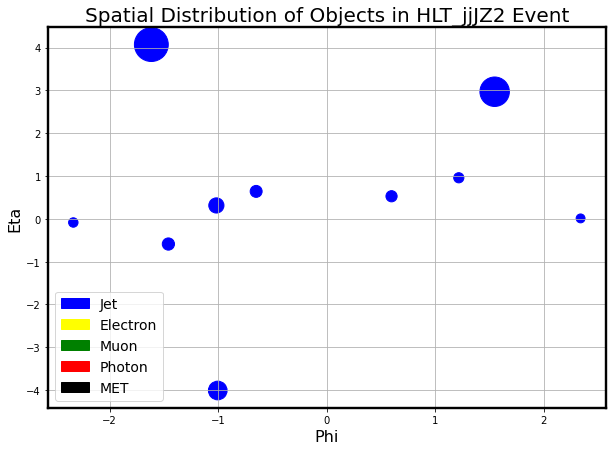

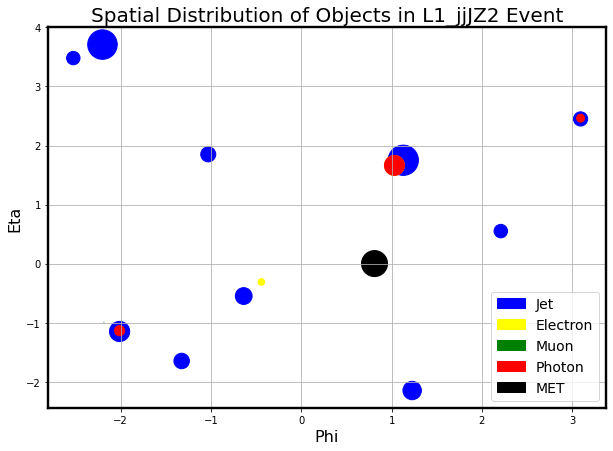

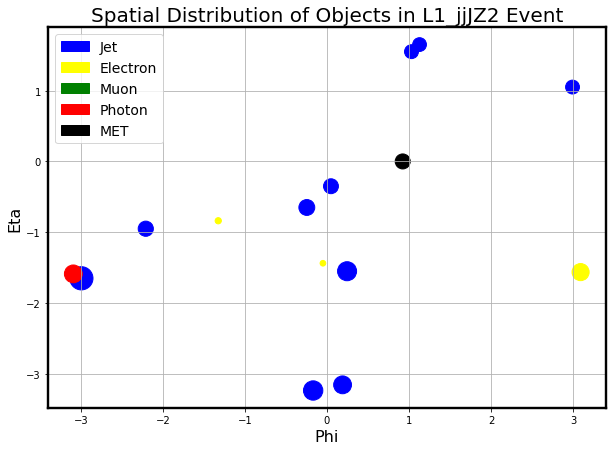

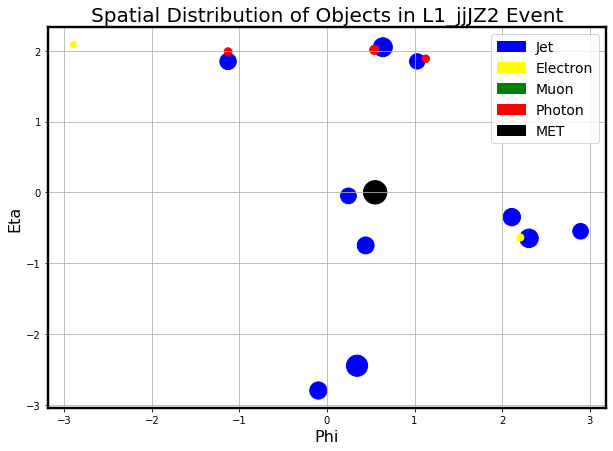

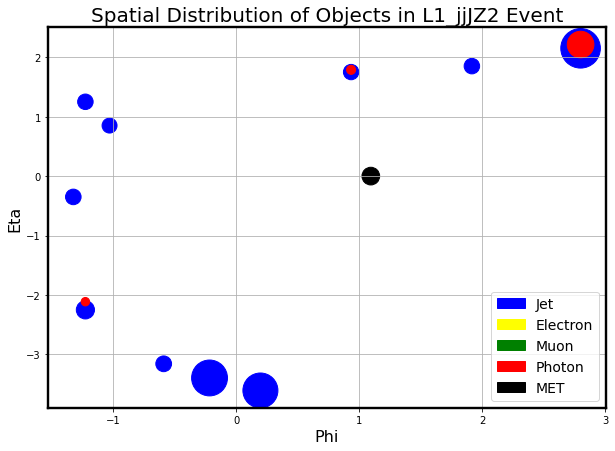

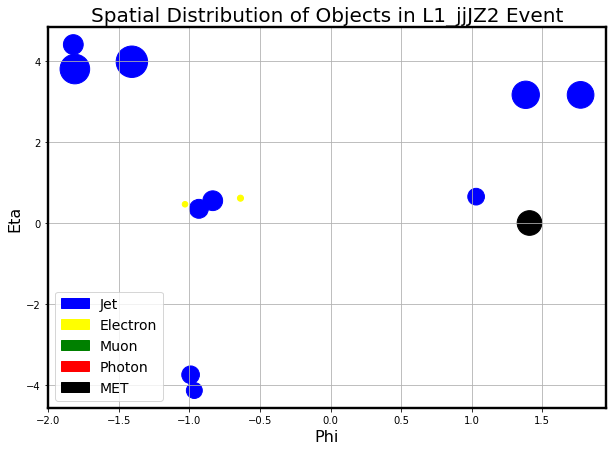

In [18]:
for tag, data in datasets.items():
    for i in range(5):
        plot_event(data[i], tag)

Event 0:


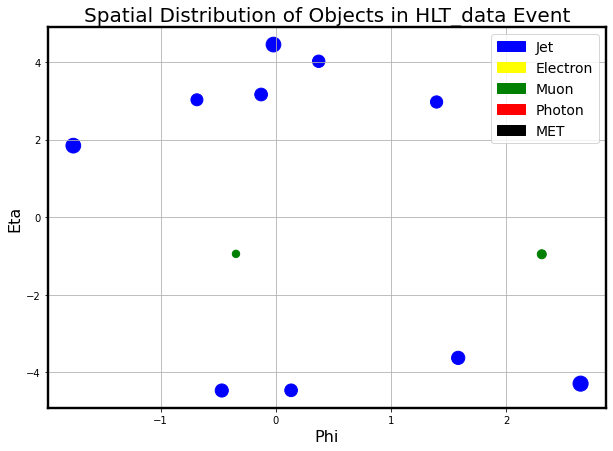

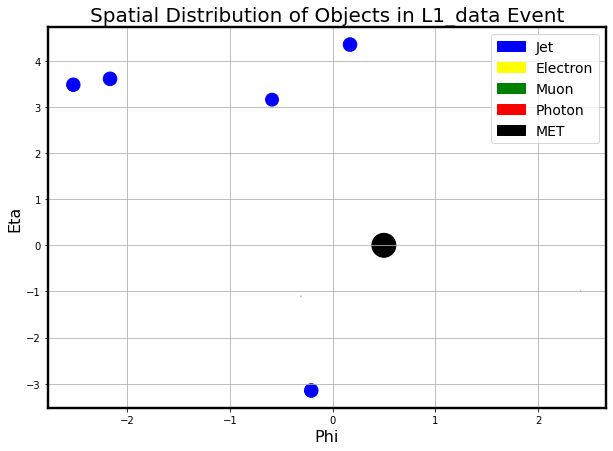





Event 1:


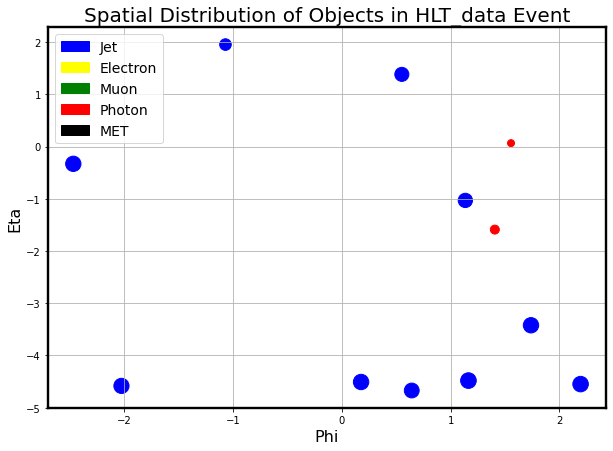

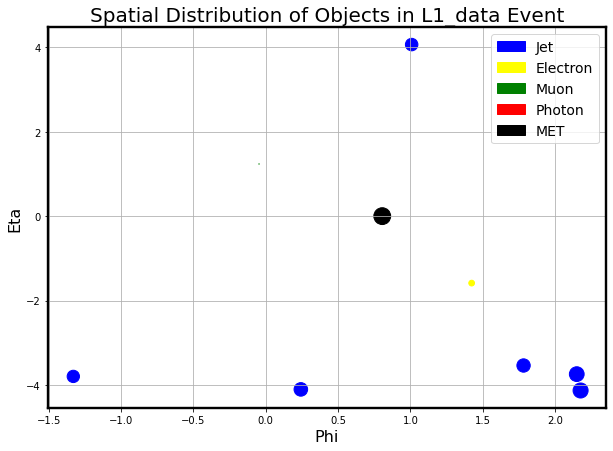





Event 2:


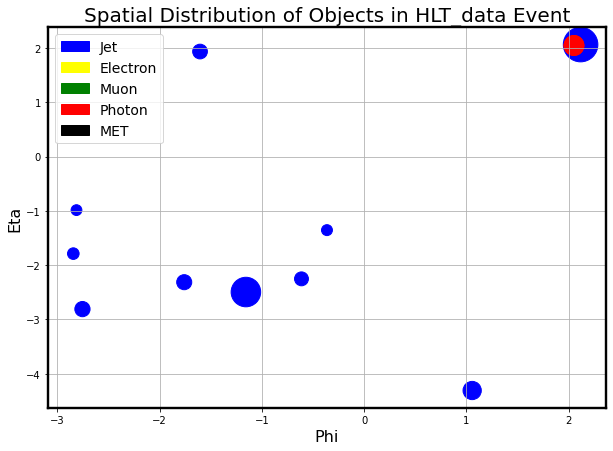

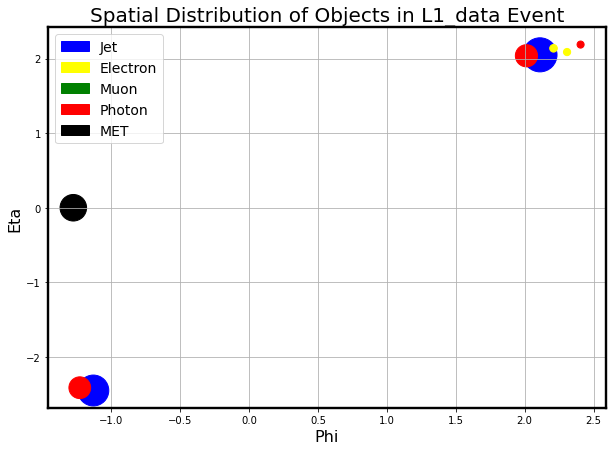





Event 3:


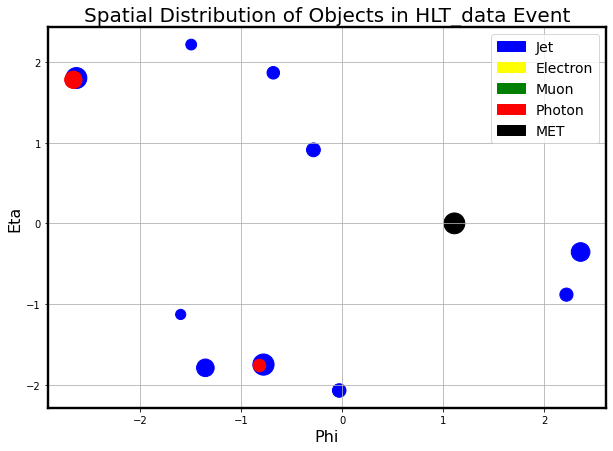

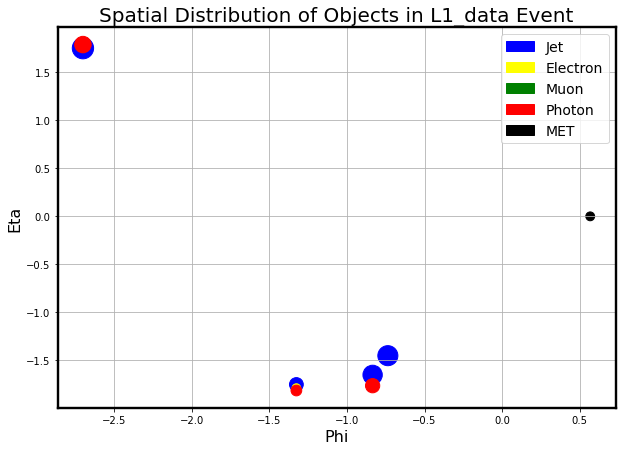





Event 4:


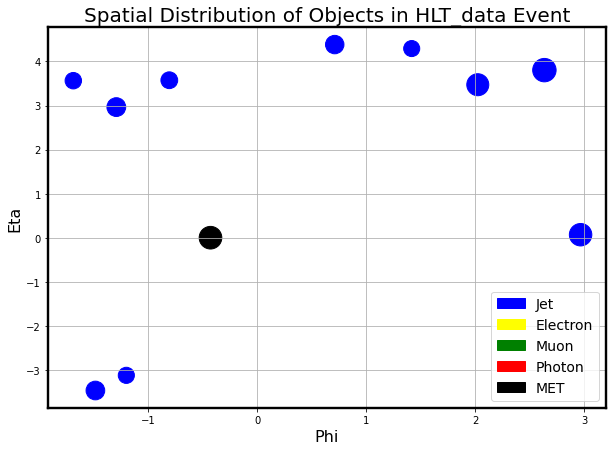

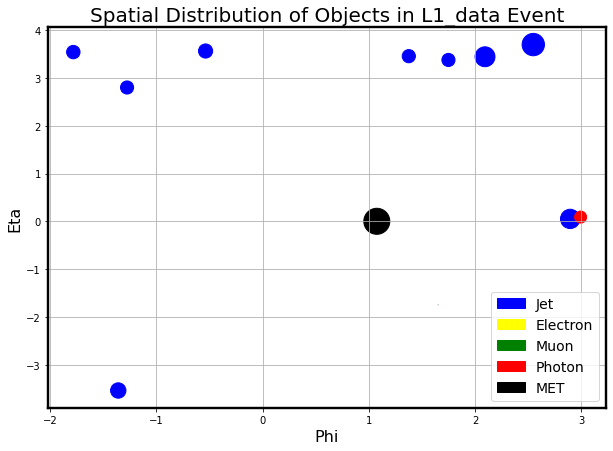

In [19]:
for i in range(5):
    print(f'Event {i}:')
    plot_event(datasets['HLT_data'][i], 'HLT_data')
    plot_event(datasets['L1_data'][i], 'L1_data')
    print('\n\n\n')

## Final preprocessing of data

In [20]:
"""Normalize pt """
for tag, data in datasets.items():
    # sum of the pt and E in each event
    sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)

    # If the sum is 0, set the sum to 1 to avoid division by 0
    sum_pt[sum_pt == 0] = 1

    # Divide pt and E by their respective sums
    data[:, :, 0] /= sum_pt

In [21]:
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (219467, 20, 3)
L1_data: (219467, 20, 3)
HLT_zerobias: (777848, 20, 3)
L1_zerobias: (777848, 20, 3)
HLT_passedHLT: (7850, 20, 3)
L1_passedHLT: (7850, 20, 3)
HLT_Ztautau: (100000, 20, 3)
HLT_ZZ4lep: (100000, 20, 3)
HLT_qqa: (50000, 20, 3)
HLT_HNL7p5_ctau1_eemu: (10000, 20, 3)
HLT_Zprime2EJs: (100000, 20, 3)
HLT_HAHMggfZdZd2l2nu: (70000, 20, 3)
HLT_HHbbttHadHad: (70000, 20, 3)
L1_HHbbttHadHad: (100000, 20, 3)
HLT_jjJZ4: (70000, 20, 3)
L1_jjJZ4: (100000, 20, 3)
HLT_jjJZ2: (70000, 20, 3)
L1_jjJZ2: (100000, 20, 3)


In [22]:
# Flatten ndarrays for use in DNN

for tag, data in datasets.items():
    datasets[tag] = np.reshape(data, newshape=(-1, 60))

for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_data: (219467, 60)
L1_data: (219467, 60)
HLT_zerobias: (777848, 60)
L1_zerobias: (777848, 60)
HLT_passedHLT: (7850, 60)
L1_passedHLT: (7850, 60)
HLT_Ztautau: (100000, 60)
HLT_ZZ4lep: (100000, 60)
HLT_qqa: (50000, 60)
HLT_HNL7p5_ctau1_eemu: (10000, 60)
HLT_Zprime2EJs: (100000, 60)
HLT_HAHMggfZdZd2l2nu: (70000, 60)
HLT_HHbbttHadHad: (70000, 60)
L1_HHbbttHadHad: (100000, 60)
HLT_jjJZ4: (70000, 60)
L1_jjJZ4: (100000, 60)
HLT_jjJZ2: (70000, 60)
L1_jjJZ2: (100000, 60)


In [23]:
# Make train, test, and val splits
# TRAIN_SIZE = 0.5
# VAL_SIZE = 0.1
# TEST_1_SIZE = 0.2
# TEST_2_SIZE = 0.2

# HLT_tags = ['train', 'val', 'test_bkg', 'test2', 'zerobias', 'Ztautau', 'HHbbttHadHad', 'ZZ4lep', 'jjJZ4', 'jjJZ2', 'qqa', 'LLP', 'dark_jets', 'dark_photons']
# HLT_datasets = []
# HLT_weights = []

# L1_tags = ['train', 'val', 'test_bkg', 'test2', 'passed_HLT', 'passed_L1', 'passed_only_L1']
# L1_datasets = []
# L1_weights = []

random_seed = 0 # random seed for replication between notebooks

# HLT -----------------------------------
# Split indices
indices = np.arange(len(datasets['HLT_data']))
train_indices, temp_indices = train_test_split(indices, train_size=0.5, random_state=random_seed)
val_indices, test_indices = train_test_split(temp_indices, train_size=0.2, random_state=random_seed)  # Adjust size as needed
test_1_indices, test_2_indices = train_test_split(test_indices, train_size=0.5, random_state=random_seed)

# Train splits
datasets['HLT_train'] = datasets['HLT_data'][train_indices]
weights['HLT_train'] = weights['HLT_data'][train_indices]
datasets['L1_train'] = datasets['L1_data'][train_indices]
weights['L1_train'] = weights['L1_data'][train_indices]
pass_HLT['HLT_train'] = pass_HLT['HLT_data'][train_indices]
pass_HLT['L1_train'] = pass_HLT['L1_data'][train_indices]

# Val splits
datasets['HLT_val'] = datasets['HLT_data'][val_indices]
weights['HLT_val'] = weights['HLT_data'][val_indices]
datasets['L1_val'] = datasets['L1_data'][val_indices]
weights['L1_val'] = weights['L1_data'][val_indices]
pass_HLT['HLT_val'] = pass_HLT['HLT_data'][val_indices]
pass_HLT['L1_val'] = pass_HLT['L1_data'][val_indices]

# Test 1 splits
datasets['HLT_test1'] = datasets['HLT_data'][test_1_indices]
weights['HLT_test1'] = weights['HLT_data'][test_1_indices]
datasets['L1_test1'] = datasets['L1_data'][test_1_indices]
weights['L1_test1'] = weights['L1_data'][test_1_indices]
pass_HLT['HLT_test1'] = pass_HLT['HLT_data'][test_1_indices]
pass_HLT['L1_test1'] = pass_HLT['L1_data'][test_1_indices]

# Test_2 splits
datasets['HLT_test2'] = datasets['HLT_data'][test_2_indices]
weights['HLT_test2'] = weights['HLT_data'][test_2_indices]
datasets['L1_test2'] = datasets['L1_data'][test_2_indices]
weights['L1_test2'] = weights['L1_data'][test_2_indices]
pass_HLT['HLT_test2'] = pass_HLT['HLT_data'][test_2_indices]
pass_HLT['L1_test2'] = pass_HLT['L1_data'][test_2_indices]

# Remove old pre-split dataset
datasets.pop('HLT_data')
datasets.pop('L1_data')
weights.pop('HLT_data')
weights.pop('L1_data')
pass_HLT.pop('HLT_data')
pass_HLT.pop('L1_data')

# Printing
for key, value in datasets.items():
    print(f'{key}: {value.shape}')

HLT_zerobias: (777848, 60)
L1_zerobias: (777848, 60)
HLT_passedHLT: (7850, 60)
L1_passedHLT: (7850, 60)
HLT_Ztautau: (100000, 60)
HLT_ZZ4lep: (100000, 60)
HLT_qqa: (50000, 60)
HLT_HNL7p5_ctau1_eemu: (10000, 60)
HLT_Zprime2EJs: (100000, 60)
HLT_HAHMggfZdZd2l2nu: (70000, 60)
HLT_HHbbttHadHad: (70000, 60)
L1_HHbbttHadHad: (100000, 60)
HLT_jjJZ4: (70000, 60)
L1_jjJZ4: (100000, 60)
HLT_jjJZ2: (70000, 60)
L1_jjJZ2: (100000, 60)
HLT_train: (109733, 60)
L1_train: (109733, 60)
HLT_val: (21946, 60)
L1_val: (21946, 60)
HLT_test1: (43894, 60)
L1_test1: (43894, 60)
HLT_test2: (43894, 60)
L1_test2: (43894, 60)


## Network Infrastructure

In [17]:
def create_AE(input_dim, h_dim_1, h_dim_2, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = layers.Dense(h_dim_2, activation='relu')(z)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    mask = mask0 * maskMET
    squared_difference = K.square(mask * (y_pred - y_true))
    return K.mean(squared_difference)

## Train

In [19]:
# Define parameters
INPUT_DIM = datasets['HLT_train'].shape[1]
H_DIM_1 = 32
H_DIM_2 = 8
LATENT_DIM = 3
STOP_PATIENCE = 8
LR_PATIENCE = 4
NUM_EPOCHS = 150
BATCH_SIZE = 512

In [22]:
# Train multiple models
for i in range(20):
    if i == 0: print('Starting!')

    # Initialize models
    HLT_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
    L1_AE = create_AE(input_dim=INPUT_DIM, h_dim_1=H_DIM_1, h_dim_2=H_DIM_2, latent_dim=LATENT_DIM)
    HLT_AE.compile(optimizer='adam', loss=loss_fn)
    L1_AE.compile(optimizer='adam', loss=loss_fn)

    # Initialize callbacks
    early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=0, min_lr=1e-6)
    callbacks = [early_stopping, reduce_lr]
    
    # train HLT model
    print(f'Starting training of HLT model {i}!')
    history_HLT = HLT_AE.fit(x=datasets['HLT_train'], y=datasets['HLT_train'], validation_data=(datasets['HLT_val'], datasets['HLT_val']), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights['HLT_train'], verbose=0)
    HLT_AE.save_weights(f'./trained_models/ensemble/HLT_{i}.keras')
    print(f'Finished training of HLT model {i}!\n\n\n')
    
    
    # train L1 model
    print(f'Starting training of L1 model {i}!')
    history_L1 = L1_AE.fit(x=datasets['L1_train'], y=datasets['L1_train'], validation_data=(datasets['L1_val'], datasets['L1_val']), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, sample_weight = weights['L1_train'], verbose=0)
    L1_AE.save_weights(f'./trained_models/ensemble/L1_{i}.keras')
    print(f'Finished training of L1 model {i}!\n\n\n')

Starting!
Starting training of HLT model 0!
Finished training of HLT model 0!



Starting training of L1 model 0!
Finished training of L1 model 0!



Starting training of HLT model 1!
Finished training of HLT model 1!



Starting training of L1 model 1!
Finished training of L1 model 1!



Starting training of HLT model 2!
Finished training of HLT model 2!



Starting training of L1 model 2!
Finished training of L1 model 2!



Starting training of HLT model 3!
Finished training of HLT model 3!



Starting training of L1 model 3!
Finished training of L1 model 3!



Starting training of HLT model 4!
Finished training of HLT model 4!



Starting training of L1 model 4!
Finished training of L1 model 4!



Starting training of HLT model 5!
Finished training of HLT model 5!



Starting training of L1 model 5!
Finished training of L1 model 5!



Starting training of HLT model 6!
Finished training of HLT model 6!



Starting training of L1 model 6!
Finished training of L1 model 6!



Starting t

## Evaluate Model

In [29]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [30]:
def AD_score(y, x):
    # masked mse
    mask = (y != 0) & (y != -999)
    _x = x * mask
    _y = y * mask
    return (mse_loss(_y, _x))

In [32]:
model_files = [f for f in os.listdir('./trained_models/ensemble') if f.endswith('.keras')]
skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val'] # Don't evaluate over train/val datasets

# Dictionary to hold the signal efficiencies and AUCs for all models
signal_efficiencies = {}
AUCs = {}

for model_file in model_files:
    model_path = os.path.join('./trained_models/ensemble', model_file)

    # Dictionaries for this specific model
    model_outputs = {}
    AD_scores = {}
    this_AUC = {}
    this_TPR = {}

    # Load model weights
    if model_file.startswith('HLT'):
        model = HLT_AE
        test_tag = 'HLT_test1'
    elif model_file.startswith('L1'):
        model = L1_AE
        test_tag = 'L1_test1'
    
    model.load_weights(model_path)

    
    target_background = np.zeros(datasets[test_tag].shape[0]) # Background for ROC curve

    # Run the data through the model
    for tag, data in datasets.items():
        if tag.startswith(model_file[0]) and tag not in skip_tags:
            model_outputs[tag] = model.predict(data)
            AD_scores[tag] = AD_score(datasets[tag], model_outputs[tag])  

    # Compute AUC and signal efficiencies
    target_fpr = 10**-4
    for tag, scores in AD_scores.items():
        
        if tag == test_tag: continue  # Skip processing the background as a signal

        trueVal = np.concatenate((np.ones(scores.shape[0]), target_background))
        predVal_loss = np.concatenate((scores, AD_scores[test_tag]))
        sample_weights = np.concatenate((weights[tag], weights[test_tag]))

        fpr_loss, tpr_loss, _ = roc_curve(trueVal, predVal_loss, sample_weight=sample_weights)
        auc_loss = auc(fpr_loss, tpr_loss)
        idx = np.argmin(np.abs(fpr_loss - target_fpr))

        this_AUC[tag] = auc_loss
        this_TPR[tag] = tpr_loss[idx]

    AUCs[model_file] = this_AUC
    signal_efficiencies[model_file] = this_TPR


1372/1372 [==============================] - 2s 2ms/step


In [33]:
print(signal_efficiencies.items())
print(AUCs.items())

dict_items([('HLT_0.keras', {'HLT_zerobias': 5.443025900671431e-05, 'HLT_passedHLT': 0.0003897675072546482, 'HLT_Ztautau': 7e-05, 'HLT_ZZ4lep': 0.00017, 'HLT_qqa': 0.0001, 'HLT_HNL7p5_ctau1_eemu': 0.0, 'HLT_Zprime2EJs': 1e-05, 'HLT_HAHMggfZdZd2l2nu': 0.0004714285714285714, 'HLT_HHbbttHadHad': 0.00011428571428571428, 'HLT_jjJZ4': 1.4285714285714285e-05, 'HLT_jjJZ2': 8.571428571428571e-05, 'HLT_test2': 2.0063572390776887e-05}), ('HLT_1.keras', {'HLT_zerobias': 5.228543980060896e-05, 'HLT_passedHLT': 0.0001948837536273246, 'HLT_Ztautau': 0.00031, 'HLT_ZZ4lep': 0.00401, 'HLT_qqa': 0.00054, 'HLT_HNL7p5_ctau1_eemu': 0.0016, 'HLT_Zprime2EJs': 0.00129, 'HLT_HAHMggfZdZd2l2nu': 0.0041285714285714285, 'HLT_HHbbttHadHad': 0.007014285714285714, 'HLT_jjJZ4': 0.0010571428571428572, 'HLT_jjJZ2': 0.0007428571428571429, 'HLT_test2': 8.02542895631088e-05}), ('HLT_10.keras', {'HLT_zerobias': 9.465610732548801e-05, 'HLT_passedHLT': 0.00019488375362732566, 'HLT_Ztautau': 0.00068, 'HLT_ZZ4lep': 0.01207, 'HLT

In [35]:
with open('./trained_models/signal_efficiencies.json', 'w') as json_file:
    json.dump(signal_efficiencies, json_file, indent=4)


with open('./trained_models/AUCs.json', 'w') as json_file:
    json.dump(AUCs, json_file, indent=4)

In [2]:
with open('./trained_models/signal_efficiencies.json', 'r') as json_file:
    signal_efficiencies = json.load(json_file)

with open('./trained_models/AUCs.json', 'r') as json_file:
    AUCs = json.load(json_file)

In [3]:
print(signal_efficiencies.keys())

dict_keys(['HLT_0.keras', 'HLT_1.keras', 'HLT_10.keras', 'HLT_11.keras', 'HLT_12.keras', 'HLT_13.keras', 'HLT_14.keras', 'HLT_15.keras', 'HLT_16.keras', 'HLT_17.keras', 'HLT_18.keras', 'HLT_19.keras', 'HLT_2.keras', 'HLT_3.keras', 'HLT_4.keras', 'HLT_5.keras', 'HLT_6.keras', 'HLT_7.keras', 'HLT_8.keras', 'HLT_9.keras', 'L1_0.keras', 'L1_1.keras', 'L1_10.keras', 'L1_11.keras', 'L1_12.keras', 'L1_13.keras', 'L1_14.keras', 'L1_15.keras', 'L1_16.keras', 'L1_17.keras', 'L1_18.keras', 'L1_19.keras', 'L1_2.keras', 'L1_3.keras', 'L1_4.keras', 'L1_5.keras', 'L1_6.keras', 'L1_7.keras', 'L1_8.keras', 'L1_9.keras'])


In [28]:
for s in signal_efficiencies.values():
    print(s.keys())

dict_keys(['HLT_zerobias', 'HLT_passedHLT', 'HLT_Ztautau', 'HLT_ZZ4lep', 'HLT_qqa', 'HLT_HNL7p5_ctau1_eemu', 'HLT_Zprime2EJs', 'HLT_HAHMggfZdZd2l2nu', 'HLT_HHbbttHadHad', 'HLT_jjJZ4', 'HLT_jjJZ2', 'HLT_test2'])
dict_keys(['HLT_zerobias', 'HLT_passedHLT', 'HLT_Ztautau', 'HLT_ZZ4lep', 'HLT_qqa', 'HLT_HNL7p5_ctau1_eemu', 'HLT_Zprime2EJs', 'HLT_HAHMggfZdZd2l2nu', 'HLT_HHbbttHadHad', 'HLT_jjJZ4', 'HLT_jjJZ2', 'HLT_test2'])
dict_keys(['HLT_zerobias', 'HLT_passedHLT', 'HLT_Ztautau', 'HLT_ZZ4lep', 'HLT_qqa', 'HLT_HNL7p5_ctau1_eemu', 'HLT_Zprime2EJs', 'HLT_HAHMggfZdZd2l2nu', 'HLT_HHbbttHadHad', 'HLT_jjJZ4', 'HLT_jjJZ2', 'HLT_test2'])
dict_keys(['HLT_zerobias', 'HLT_passedHLT', 'HLT_Ztautau', 'HLT_ZZ4lep', 'HLT_qqa', 'HLT_HNL7p5_ctau1_eemu', 'HLT_Zprime2EJs', 'HLT_HAHMggfZdZd2l2nu', 'HLT_HHbbttHadHad', 'HLT_jjJZ4', 'HLT_jjJZ2', 'HLT_test2'])
dict_keys(['HLT_zerobias', 'HLT_passedHLT', 'HLT_Ztautau', 'HLT_ZZ4lep', 'HLT_qqa', 'HLT_HNL7p5_ctau1_eemu', 'HLT_Zprime2EJs', 'HLT_HAHMggfZdZd2l2nu', 'HLT_

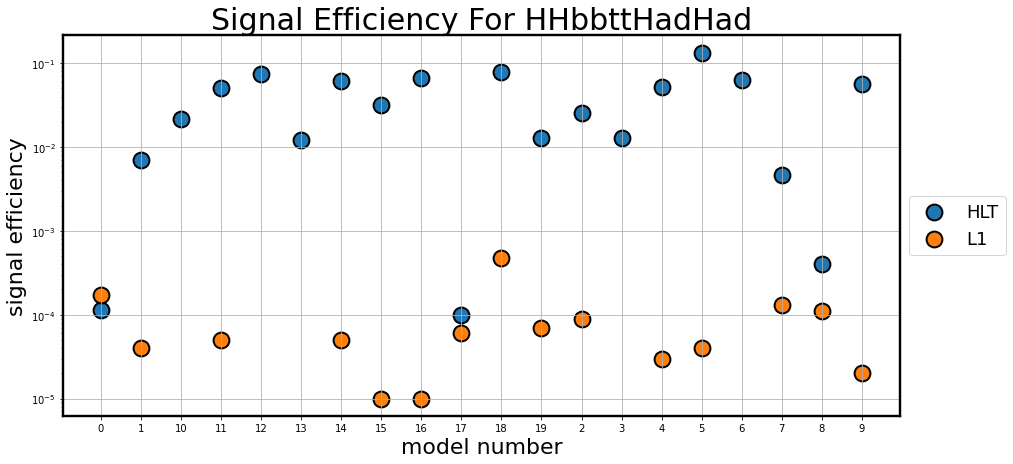

In [73]:
good_tags = ['HLT_HHbbttHadHad', 'L1_HHbbttHadHad']
plt.figure(figsize=(15, 7))


for tag in good_tags:
    TPR = []
    model_ids = []
    # L1_TPR = []
    # L1_model_ids = []
    for model_id, TPR_dict in signal_efficiencies.items():
        if model_id[0:2] == tag[0:2]:
            model_ids.append(model_id.split('_')[1].split('.')[0])
            TPR.append(TPR_dict[tag])
    
    plt.scatter(model_ids, TPR, label=tag.split('_')[0], s=250, edgecolors='k', linewidth=2)

plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('model number', fontsize=22)
plt.title(f"Signal Efficiency For {good_tags[0].split('_')[1]}", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

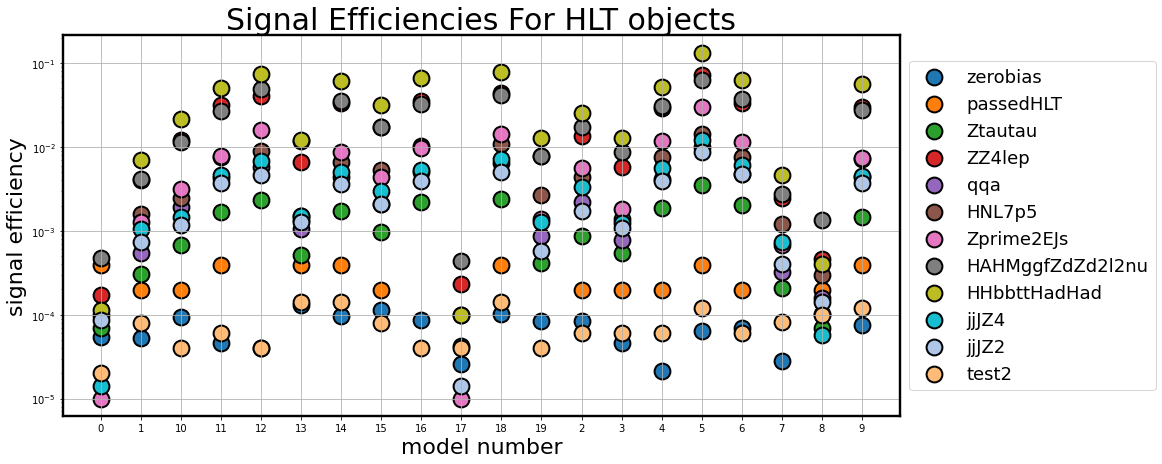

In [76]:
skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val', 'HLT_test1', 'L1_test1']
good_tags = [tag for tag in datasets.keys() if tag.startswith('HLT') and tag not in skip_tags]

plt.figure(figsize=(15, 7))
for tag in good_tags:
    TPR = []
    model_ids = []
    # L1_TPR = []
    # L1_model_ids = []
    for model_id, TPR_dict in signal_efficiencies.items():
        if model_id[0:2] == tag[0:2]:
            model_ids.append(model_id.split('_')[1].split('.')[0])
            TPR.append(TPR_dict[tag])
    
    plt.scatter(model_ids, TPR, label=tag.split('_')[1], s=250, edgecolors='k', linewidth=2)

plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('model number', fontsize=22)
plt.title(f"Signal Efficiencies For Each Signal", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

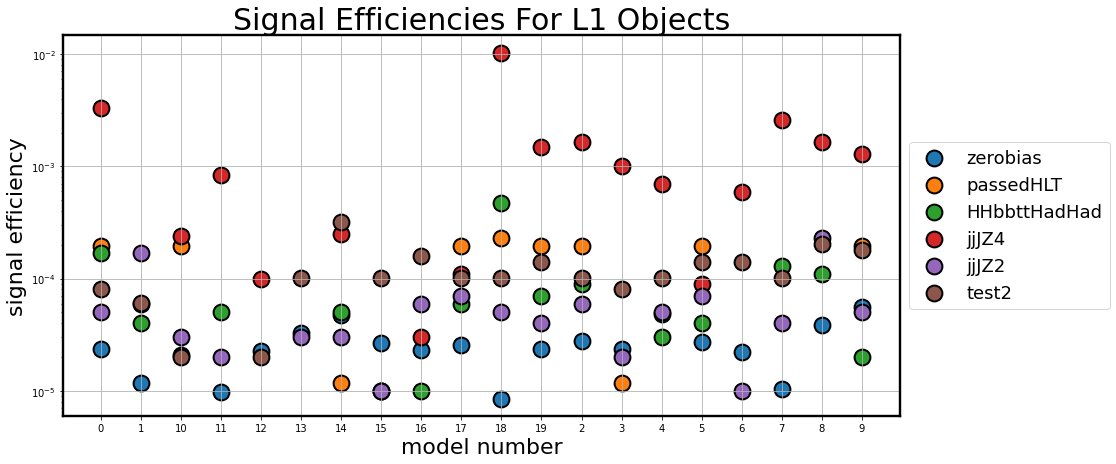

In [77]:
skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val', 'HLT_test1', 'L1_test1']
good_tags = [tag for tag in datasets.keys() if tag.startswith('L1') and tag not in skip_tags]

plt.figure(figsize=(15, 7))
for tag in good_tags:
    TPR = []
    model_ids = []
    # L1_TPR = []
    # L1_model_ids = []
    for model_id, TPR_dict in signal_efficiencies.items():
        if model_id[0:2] == tag[0:2]:
            model_ids.append(model_id.split('_')[1].split('.')[0])
            TPR.append(TPR_dict[tag])
    
    plt.scatter(model_ids, TPR, label=tag.split('_')[1], s=250, edgecolors='k', linewidth=2)

plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('model number', fontsize=22)
plt.title(f"Signal Efficiencies For L1 Objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

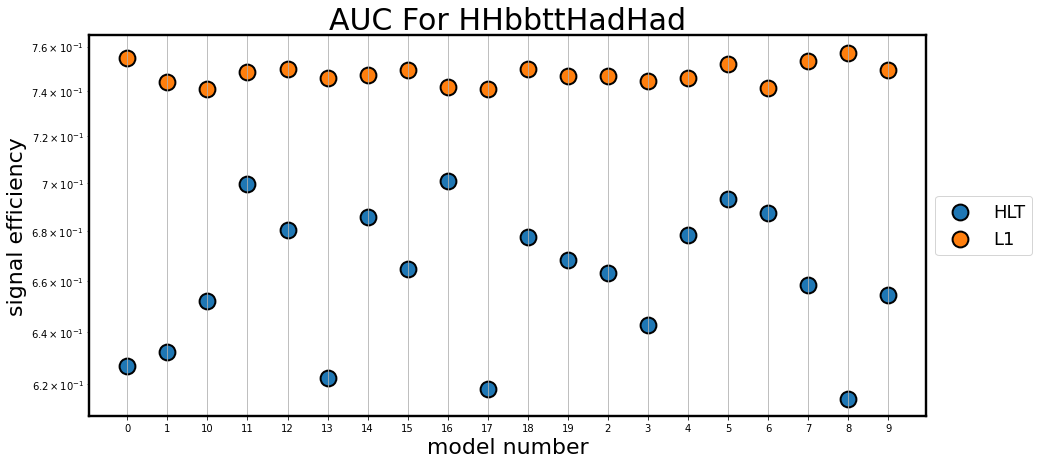

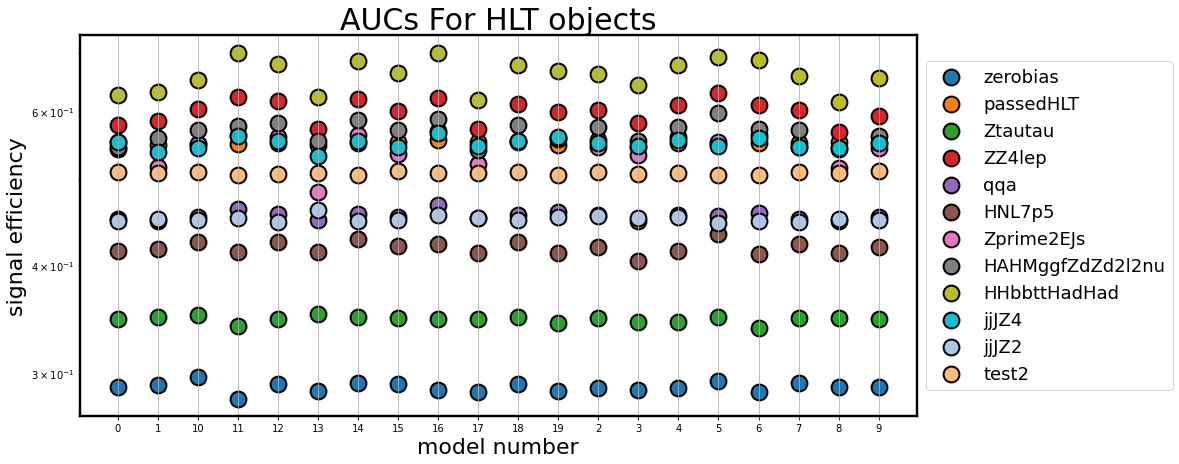

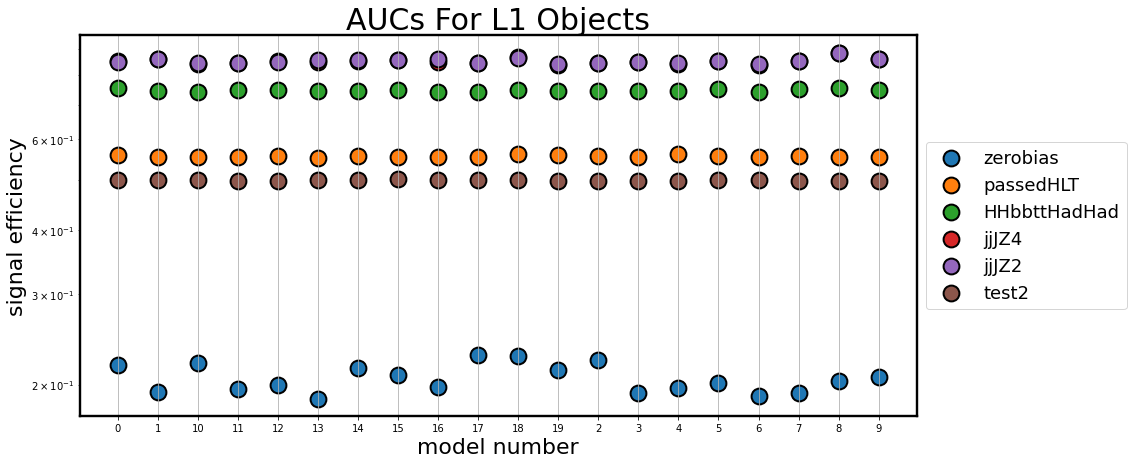

In [79]:
good_tags = ['HLT_HHbbttHadHad', 'L1_HHbbttHadHad']
plt.figure(figsize=(15, 7))


for tag in good_tags:
    AUC = []
    model_ids = []
    # L1_AUC = []
    # L1_model_ids = []
    for model_id, AUC_dict in AUCs.items():
        if model_id[0:2] == tag[0:2]:
            model_ids.append(model_id.split('_')[1].split('.')[0])
            AUC.append(AUC_dict[tag])
    
    plt.scatter(model_ids, AUC, label=tag.split('_')[0], s=250, edgecolors='k', linewidth=2)

plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('model number', fontsize=22)
plt.title(f"AUC For {good_tags[0].split('_')[1]}", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val', 'HLT_test1', 'L1_test1']
good_tags = [tag for tag in datasets.keys() if tag.startswith('HLT') and tag not in skip_tags]

plt.figure(figsize=(15, 7))
for tag in good_tags:
    AUC = []
    model_ids = []
    # L1_AUC = []
    # L1_model_ids = []
    for model_id, AUC_dict in AUCs.items():
        if model_id[0:2] == tag[0:2]:
            model_ids.append(model_id.split('_')[1].split('.')[0])
            AUC.append(AUC_dict[tag])
    
    plt.scatter(model_ids, AUC, label=tag.split('_')[1], s=250, edgecolors='k', linewidth=2)

plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('model number', fontsize=22)
plt.title(f"AUCs For HLT objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val', 'HLT_test1', 'L1_test1']
good_tags = [tag for tag in datasets.keys() if tag.startswith('L1') and tag not in skip_tags]

plt.figure(figsize=(15, 7))
for tag in good_tags:
    AUC = []
    model_ids = []
    # L1_AUC = []
    # L1_model_ids = []
    for model_id, AUC_dict in AUCs.items():
        if model_id[0:2] == tag[0:2]:
            model_ids.append(model_id.split('_')[1].split('.')[0])
            AUC.append(AUC_dict[tag])
    
    plt.scatter(model_ids, AUC, label=tag.split('_')[1], s=250, edgecolors='k', linewidth=2)

plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('model number', fontsize=22)
plt.title(f"AUCs For L1 Objects", fontsize=30)
plt.grid()
plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

average signal efficiency for HLT_zerobias = 7.102067746947945e-05
average signal efficiency for HLT_passedHLT = 0.00021477499709917158
average signal efficiency for HLT_Ztautau = 0.0011979999999999998
average signal efficiency for HLT_ZZ4lep = 0.021120999999999997
average signal efficiency for HLT_qqa = 0.0029690000000000003
average signal efficiency for HLT_HNL7p5_ctau1_eemu = 0.0051199999999999996
average signal efficiency for HLT_Zprime2EJs = 0.006843
average signal efficiency for HLT_HAHMggfZdZd2l2nu = 0.021489285714285718
average signal efficiency for HLT_HHbbttHadHad = 0.03838357142857143
average signal efficiency for HLT_jjJZ4 = 0.003572142857142857
average signal efficiency for HLT_jjJZ2 = 0.0025821428571428566
average signal efficiency for HLT_test2 = 7.637317993433805e-05


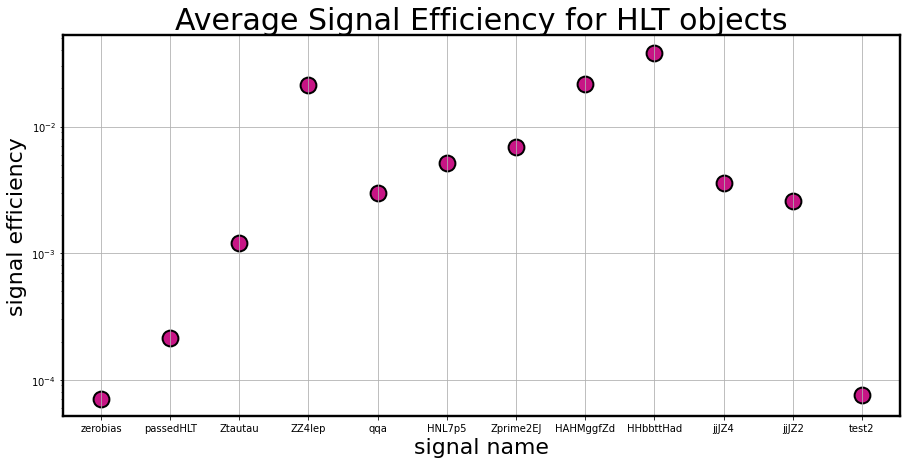

In [93]:
skip_tags = ['HLT_train', 'HLT_val', 'L1_train', 'L1_val', 'HLT_test1', 'L1_test1']
good_tags = [tag for tag in datasets.keys() if tag.startswith('HLT') and tag not in skip_tags]

plt.figure(figsize=(15, 7))
mean_TPR = []
signal_names = []
for tag in good_tags:
    signal_names.append(tag.split('_')[1][0:9])
    TPR = []
    # L1_TPR = []
    # L1_model_ids = []
    for model_id, TPR_dict in signal_efficiencies.items():
        if model_id[0:2] == tag[0:2]:
            model_ids.append(model_id.split('_')[1].split('.')[0])
            TPR.append(TPR_dict[tag])
    mean_TPR.append(np.mean(TPR))
    print(f'average signal efficiency for {tag} = {np.mean(TPR)}')
    
    #plt.scatter(model_ids, TPR, label=tag.split('_')[1], s=250, edgecolors='k', linewidth=2)

plt.scatter(signal_names, mean_TPR, s=250, edgecolors='k', linewidth=2, color='mediumvioletred')
plt.yscale('log')
plt.ylabel('signal efficiency', fontsize=22)
plt.xlabel('signal name', fontsize=22)
plt.title(f"Average Signal Efficiency for HLT objects", fontsize=30)
plt.grid()
#plt.legend(fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()